# <center> Themes and schemantics

The aim of this exploration is:
 - **Topic 1:** Wordcloud des mots les plus fréquents dans les captions gagnantes vs. celles les moins drôles
 - 
 - 
 - 

# Initialisation –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

Importing the necessary stuff

In [1]:
# Text analysis
import re
import string
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer  # <== use this instead

# Text visualisiation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Statistical modeling
import statsmodels.api as sm


nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

tokenizer = TreebankWordTokenizer()

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
import sys
sys.path.append("..")   # path *relative* to your notebook
from DataPreparation import dataA, dataC

dataA[0].head()  # first 5 rows

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

# Topic 1 –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

<p style="text-align: center;"><em>Wordcloud des mots les plus fréquents dans les captions gagnantes vs. celles les moins drôles</em></p>

Aim of this topic:
 - Find most frequent words in winning captions: limit search in the beginning to top 100 comments
 - Find most frequent words in Least funny captions: This could be done by looking at the final 1000 comments.

A conceptual question arises. Do we simply work with ranking, higher rank meaning less funny? Or do we introduce a funniness score:
$$
\text{Funniness\_score} = \frac{\omega_1\cdot\text{funny} + \omega_2\cdot\text{somewhat\_funny} + \omega_3 \cdot\text{not\_funny}}{\text{number\_of\_votes}}
$$
I will conduct both analyses. For the weights, I will introduce a linear model to learn how the funniness is actually decided.

In [13]:
# I will make the rank a new column, not an index
dfs_fixed = []
for i, d in enumerate(dataA):
    d = d.reset_index()
    d['contest_id'] = i + 510  # contests start at 510
    dfs_fixed.append(d)

combinedA = pd.concat(dfs_fixed, ignore_index=True)

# Normalising ranking to [0,1]
combinedA['rank_norm'] = combinedA.groupby('contest_id')['rank'].transform(lambda r: r / r.max())

combinedA['p_funny'] = combinedA['funny'] / combinedA['votes']
combinedA['p_somewhat'] = combinedA['somewhat_funny'] / combinedA['votes']
combinedA['p_not'] = combinedA['not_funny'] / combinedA['votes']

X = combinedA[['p_funny', 'p_somewhat', 'p_not']]
y = combinedA['rank_norm']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

w1, w2, w3 = -model.params['p_funny'], -model.params['p_somewhat'], -model.params['p_not']
weights = [w / sum([w1, w2, w3]) for w in [w1, w2, w3]]
print("Normalised weights:", weights)

                            OLS Regression Results                            
Dep. Variable:              rank_norm   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 1.558e+06
Date:                Mon, 13 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:44:20   Log-Likelihood:             8.6905e+05
No. Observations:             2292678   AIC:                        -1.738e+06
Df Residuals:                 2292674   BIC:                        -1.738e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6020      0.103     -5.843      0.0

The results are promising and make sense intuitively. We found that the having more funny votes will lead to a better rank (lower rank value) and same for somewhat funny. This is seen by the negative coefficient "p\_funny" and "p\_somewhat". The weights in the funniness score are then inversed, since we will define funnier as higher funniness score. We allow negative funniness: thats when there are many more not funny votes than funny votes.

In [14]:
# Add a funniness score to the dataframes
dataA1 = dataA.copy()
for d in dataA1:
    d['funniness_score'] = (weights[0] * d['funny'] + weights[1] * d['somewhat_funny'] + weights[2] * d['not_funny']) / d['votes']

In [15]:
# Basic list of common English stopwords (can be expanded) -> necessary since nltk stopwords is bugging
STOPWORDS = {
    # --- pronouns and determiners ---
    "i","me","my","myself","we","our","ours","ourselves","you","your","yours",
    "yourself","yourselves","he","him","his","himself","she","her","hers","herself",
    "it","its","itself","they","them","their","theirs","themselves","us",
    "what","which","who","whom","this","that","these","those",
    
    # --- auxiliary verbs & modals ---
    "am","is","are","was","were","be","been","being","have","has","had","having",
    "do","does","did","doing","can","could","will","would","shall","should","may",
    "might","must","ought",
    
    # --- articles, prepositions, conjunctions ---
    "a","an","the","and","but","if","or","because","as","until","while","of","at",
    "by","for","with","about","against","between","into","through","during","before",
    "after","above","below","to","from","up","down","in","out","on","off","over",
    "under","again","further","then","once","here","there","when","where","why",
    "how","all","any","both","each","few","more","most","other","some","such","no",
    "nor","not","only","own","same","so","than","too","very","s","t","now","just",
    
    # --- contractions & spoken forms ---
    "im","ive","id","youre","youve","youd","hes","shes","theyre","theyve","weve",
    "wed","dont","doesnt","didnt","cant","couldnt","wont","wouldnt","shouldnt",
    "isnt","arent","wasnt","werent","thats","theres","whats","whos","hows","lets",
    "re","don","ill", "ll","d","ve","y","ma",
    
    # --- generic filler verbs & expressions ---
    "get","got","getting","go","goes","going","gone","see","saw","seen","say",
    "says","said","make","makes","made","know","knows","knew","think","thinks",
    "thought","need","needs","needed","want","wants","wanted","like","likes",
    "liked","use","used","using","try","trying","tried","work","works","worked",
    "take","takes","took","put","puts","doing","done","give","gives","gave",
    
    # --- discourse fillers ---
    "well","really","one","even","still","lot","thats","thing","things","way",
    "something","anything","everything","nothing","time","back","new","also",
    "ever","always","maybe"
}


# Now, we can do the word frequency analysis on dataA1
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # regex tokenise (words of length ≥2)
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    # remove stopwords
    tokens = [t for t in tokens if t not in STOPWORDS]
    return tokens

We now tokenize our text. This will allow us to count occurences of words easily.

In [16]:
dataA2 = dataA1.copy()
# applying the tokenization and cleaning function to the captions
# This adds a new column 'tokens' to each dataframe in dataA1
for d in dataA2:
    d['tokens'] = d['caption'].apply(preprocess_text)

# Takes around 30 secs

List of most common words that are not in the stopwords list

In [17]:
# Combining all tokens from all dataframes
all_tokens = []
for d in dataA2:
    all_tokens.extend([word for tokens in d['tokens'] for word in tokens])

# Count word frequencies
word_counts = Counter(all_tokens)

print(word_counts.most_common(20))

[('look', 40345), ('told', 38502), ('good', 37717), ('right', 36730), ('sorry', 35736), ('never', 31405), ('tell', 31360), ('little', 30948), ('sure', 29617), ('next', 29541), ('last', 29407), ('yes', 29157), ('first', 27599), ('let', 26235), ('looks', 24902), ('better', 24838), ('feel', 24778), ('come', 24664), ('much', 24077), ('oh', 23889)]


Now, let us count the most common words in the top 100 comments, and do the same for the last 1000 comments.

In [18]:
# Count word frequencies in top 100 and bottom 1000 comments. BASED ON FUNNINESS SCORE
top_100_tokens = []
bottom_1000_tokens = []
for d in dataA2:
    top_100 = d.nlargest(100, 'funniness_score')
    bottom_1000 = d.nsmallest(1000, 'funniness_score')
    top_100_tokens.extend([word for tokens in top_100['tokens'] for word in tokens])
    bottom_1000_tokens.extend([word for tokens in bottom_1000['tokens'] for word in tokens])

top_100_counts = Counter(top_100_tokens)
bottom_1000_counts = Counter(bottom_1000_tokens)


In [19]:
# Some stuff
print("Top 20 words in top 100 comments:", top_100_counts.most_common(20))
print("Top 20 words in bottom 1000 comments:", bottom_1000_counts.most_common(20))

# find words that appear in top 100 but not in bottom 1000
unique_top_words = set(top_100_counts) - set(bottom_1000_counts)
print("Words in top 100 but not in bottom 1000:", unique_top_words)

# find words that appear in top 100 but not in bottom 1000, but only those that appear at least 3 times in top 100
unique_top_words_5 = {word for word in unique_top_words if top_100_counts[word] >= 3}
print("Words in top 100 but not in bottom 1000 (at least 3 occurrences):", unique_top_words_5)

Top 20 words in top 100 comments: [('look', 740), ('right', 685), ('good', 664), ('first', 600), ('last', 590), ('tell', 555), ('never', 554), ('let', 540), ('yes', 528), ('sorry', 486), ('sure', 483), ('little', 460), ('next', 449), ('told', 449), ('call', 445), ('come', 416), ('looks', 402), ('home', 390), ('much', 385), ('better', 370)]
Top 20 words in bottom 1000 comments: [('told', 7020), ('look', 6701), ('sorry', 6564), ('good', 6331), ('right', 6314), ('never', 5228), ('little', 5208), ('next', 5113), ('tell', 5071), ('sure', 4998), ('last', 4783), ('come', 4592), ('oh', 4481), ('yes', 4446), ('let', 4432), ('much', 4332), ('first', 4295), ('better', 4245), ('looks', 4113), ('please', 4094)]
Words in top 100 but not in bottom 1000: {'greatjust', 'twohunter', 'highlighter', 'latemidlife', 'wascolby', 'hanchoring', 'sanctimony', 'personalinjury', 'weyou', 'marshallthere', 'outbecause', 'henderman', 'germanmade', 'instills', 'sunroom', 'arrivedlets', 'bedone', 'veople', 'tubso', 'm

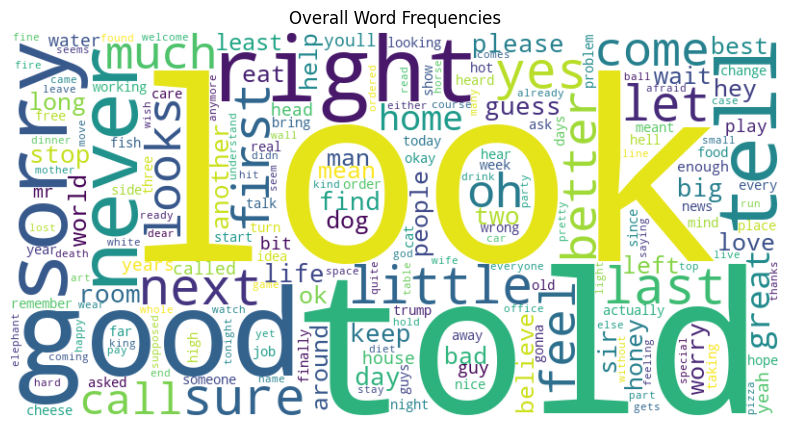

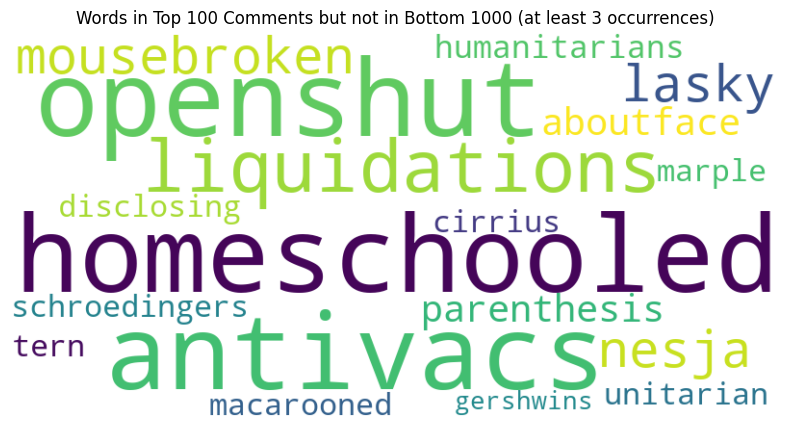

In [20]:
# Visualisation of word frequencies using wordcloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.title('Overall Word Frequencies')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# same for top unique_top_words_5
unique_top_words_5_freq = {word: top_100_counts[word] for word in unique_top_words_5}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unique_top_words_5_freq)
plt.figure(figsize=(10, 5))
plt.title('Words in Top 100 Comments but not in Bottom 1000 (at least 3 occurrences)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Topic 2 –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

<p style="text-align: center;"><em>Fréquence des entités (issues de entities du metadata) dans les captions et leur score moyen.</em></p>

In [21]:
dataC1 = dataC.copy()
dataC1

num_captions  num_votes                          image_locations  \
0          3905.0    41185.0                             [the street]   
1          3325.0    28205.0  [the front hard, a residential walkway]   
2          4399.0    21574.0              [yoga place, a yoga studio]   
3          4141.0    16894.0               [a workplace, an elevator]   
4          3951.0    95790.0                                 [plains]   
..            ...        ...                                      ...   
379           NaN        NaN                                      NaN   
380           NaN        NaN                                      NaN   
381           NaN        NaN                                      NaN   
382           NaN        NaN                                      NaN   
383           NaN        NaN                                      NaN   

                                    image_descriptions  \
0    [A man is relaxing on a city street. Others ar...   
1    [A man in a winter coat and cap is looking at ...   
2    [A man and woman are standing facing one anoth...   
3    [Three business men are walking down a hall. T...   
4    [Some cowboys are riding through the desert. T...   
..                                                 ...   
379                                                NaN   
380                                                NaN   
381                                                NaN   
382                                                NaN   
383                                                NaN   

                            image_uncanny_descriptions  \
0    [A man is just laying in the middle of the sid...   
1    [It's unusual to see someone holding a snow sh...   
2    [Nothing is really out of place in this image....   
3    [A suit case is usually carried by one person ...   
4    [There are rocking horses in place of real hor...   
..                                                 ...   
379                                                NaN   
380                                                NaN   
381                                                NaN   
382                                                NaN   
383                                                NaN   

                                              entities  \
0    [https://en.wikipedia.org/wiki/Bystander_effec...   
1    [https://en.wikipedia.org/wiki/Snowball_fight,...   
2    [https://en.wikipedia.org/wiki/Rug, https://en...   
3    [https://en.wikipedia.org/wiki/Worker_cooperat...   
4    [https://en.wikipedia.org/wiki/Rocking_horse, ...   
..                                                 ...   
379                                                NaN   
380                                                NaN   
381                                                NaN   
382                                                NaN   
383                                                NaN   

                                             questions       date  
0                            [Why is he laying there?]        NaT  
1    [Is the man overly small or the shovel overly ...        NaT  
2    [Why is the man carrying a huge rug?, Why is t... 2016-03-21  
3    [Why is the briefcase big enough for three peo... 2016-03-27  
4                    [Why is this chase taking place?] 2016-04-03  
..                                                 ...        ...  
379                                                NaN        NaT  
380                                                NaN        NaT  
381                                                NaN        NaT  
382                                                NaN        NaT  
383                                                NaN        NaT  

[384 rows x 8 columns]

Notice, we know the location of certain images. Count which occurs and how often!

In [22]:
# Counting the locations in the location column


Here, we want to count the number of objects occuring in captions. We also want to somehow see what occurs in the funniest comments, as well as in least funny comments.

In [23]:
%pip install --upgrade nltk
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk import pos_tag, word_tokenize
print(pos_tag(word_tokenize("The cat sat on the mat.")))

def extract_nouns_nltk(entry):
    """Extract nouns whether the entry is a string or a list of strings."""
    if isinstance(entry, list):
        text = " ".join(entry)
    elif isinstance(entry, str):
        text = entry
    else:
        return []

    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    nouns = [word for word, pos in tagged if pos.startswith('NN')]
    return nouns

dataC1['nouns'] = dataC1['image_descriptions'].apply(extract_nouns_nltk)
dataC1['uncanny nouns'] = dataC1['image_uncanny_descriptions'].apply(extract_nouns_nltk)
dataC1['questions nouns'] = dataC1['questions'].apply(extract_nouns_nltk)

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\andra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to C:\Users\andra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[('The', 'DT'), ('cat', 'NN'), ('sat', 'VBD'), ('on', 'IN'), ('the', 'DT'), ('mat', 'NN'), ('.', '.')]


In [24]:
# Count the occurence of nouns overall
all_nouns = []
for col in ['nouns', 'uncanny nouns', 'questions nouns']:
    all_nouns.extend([word for tokens in dataC1[col] for word in tokens])
noun_counts = Counter(all_nouns)
print("Most common nouns overall:", noun_counts.most_common(1000))
print("Most common nouns in image descriptions:", Counter([word for tokens in dataC1['nouns'] for word in tokens]).most_common(1000))
print("Most common nouns in uncanny descriptions:", Counter([word for tokens in dataC1['uncanny nouns'] for word in tokens]).most_common(1000))
print("Most common nouns in questions:", Counter([word for tokens in dataC1['questions nouns'] for word in tokens]).most_common(1000))

Most common nouns overall: [('man', 494), ('people', 169), ('woman', 147), ('room', 67), ('men', 64), ('office', 59), ('table', 53), ('head', 43), ('couple', 42), ('house', 41), ('person', 39), ('face', 39), ('restaurant', 37), ('doctor', 37), ('dog', 35), ('living', 34), ('king', 33), ('place', 33), ('top', 31), ('waiter', 30), ('front', 29), ('water', 29), ('hair', 29), ('animals', 29), ('bar', 28), ('car', 27), ('fish', 27), ('mountain', 25), ('clothes', 25), ('whale', 24), ('island', 24), ('middle', 24), ('kitchen', 24), ('caveman', 24), ('someone', 23), ('way', 23), ('knight', 22), ('cat', 22), ('boy', 21), ('desert', 21), ('building', 21), ('paper', 21), ('cave', 21), ('dogs', 21), ('bird', 20), ('birds', 20), ('bunch', 20), ('shop', 20), ('piano', 20), ('horse', 20), ('ground', 19), ('couch', 19), ('wall', 19), ('store', 19), ('suit', 19), ('baseball', 19), ('time', 19), ('city', 18), ('door', 18), ('hand', 17), ('window', 17), ('shark', 17), ('food', 17), ('phone', 17), ('earth

So we could count the occurence of nouns overall in all comments. Lets visualise this, maybe after categorising them?

In [25]:
# Some chatGPT suggestions for categories
noun_categories = {
    # People & Professions
    'people': {
        'man','men','woman','women','people','person','couple','boy','girl','lady',
        'husband','wife','king','queen','prince','princess','knight','boss','client',
        'lawyer','judge','doctor','scientist','psychiatrist','therapist','chef','baker',
        'bartender','waiter','waitress','businessman','businesswoman','worker','employee',
        'manager','customer','patron','guard','cop','policeman','officer','soldier','hunter',
        'cowboy','shepherd','priest','god','angel','devil','reaper','mobster','barber',
        'artist','musician','coach','scientist','explorer','astronaut','vendor','teacher',
        'realtor','psychiastrist','hitchhiker','host','usher','attendant','judge','realtor',
        'coach','author','assistant','farmer','rancher'
    },

    # Animals
    'animals': {
        'dog','dogs','cat','cats','bird','birds','fish','whale','whales','shark','sharks',
        'dolphin','dolphins','bear','bears','wolf','wolves','horse','horses','elephant',
        'giraffe','giraffes','lizard','lizards','reptile','dinosaur','dinosaurs','rabbit',
        'sheep','mouse','mice','rat','rats','snail','monkey','monkeys','pigs','ducks','deer',
        'hamster','bull','goat','dragon','dragons','wolf','werewolf','werewolves','yeti',
        'unicorn','centaur','mammoths','alligator','alligators','crocodile','creatures',
        'beast','cowboys','dogs','cats','animal','animals','giraffes','gators'
    },

    # Objects & Everyday Items
    'objects': {
        'table','tables','chair','chairs','desk','desks','suit','suits','clothes','clothing',
        'shirt','jackets','tie','coat','suitcase','briefcase','bag','bags','cup','cups','mug',
        'glass','glasses','bottle','lamp','phone','phones','cellphone','computer','computers',
        'tv','screen','window','windows','door','doors','paper','papers','book','books',
        'clipboard','sign','signs','machine','machines','instrument','instruments','guitar',
        'piano','tuba','drum','pen','pencil','scissors','brush','robe','apron','hat','hats',
        'cap','crown','shoes','boots','socks','uniform','outfit','outfits','gear','costume',
        'costumes','umbrella','lamp','clipboard','bucket','buckets','clock','frame','mirror',
        'rope','chain','cart','box','boxes','board','boards','stool','stools','coat','jackets'
    },

    # Places & Settings
    'places': {
        'room','office','building','buildings','store','shop','restaurant','bar','cafe',
        'court','courtroom','city','street','park','house','houses','home','apartment',
        'museum','castle','workplace','desert','island','mountain','mountains','cave','caves',
        'beach','kitchen','church','elevator','road','forest','woods','gallery','hospital',
        'sidewalk','corner','sky','tower','hall','hallway','block','station','subway','alley',
        'yard','field','ranch','countryside','yard','plains','path','studio','balcony','space'
    },

    # Nature & Environment
    'nature': {
        'earth','ocean','sea','water','air','fire','sand','tree','trees','cactus','cacti',
        'flowers','leaves','grass','snow','rain','cloud','clouds','sun','sky','moon','wind',
        'hill','rock','rocks','ground','soil','planet','planets','mountain','mountains',
        'environment','nature','beach','island','forest','woods','desert'
    },

    # Fantasy, Religion & Myth
    'fantasy': {
        'angel','angels','god','devil','satan','reaper','heaven','hell','ghost','spirit',
        'knight','king','queen','prince','princess','crown','dragon','dragons','genie',
        'centaur','vampire','wizard','magician','myth','throne','castle','werewolf',
        'werewolves','rapunzel','moses','adam','eden','reaper','saint','prophet'
    },

    # Work & Business Contexts
    'work': {
        'office','desk','desks','meeting','business','workers','employee','boss','lawyer',
        'judge','court','courtroom','document','papers','briefcase','chart','presentation',
        'computer','computers','report','file','customer','client','deal','stock','stocks',
        'job','manager','coworker','executives','company','factory','lab','scientist',
        'scientists','workplace','work','employee','employers','meeting','psychiastrist',
        'realtor','clerk','cashier','shop','barber','assistant','vendor','therapist'
    },

    # Food & Dining
    'food': {
        'restaurant','bar','bartender','waiter','waitress','menu','cake','food','drink',
        'drinks','coffee','wine','beer','pizza','soup','sandwich','meat','bowl','plate',
        'table','tables','dinner','lunch','breakfast','chef','baker','oven','kitchen',
        'refrigerator','fridge','cup','mug','spoon','fork','dessert','pie','hotdog','pancake',
        'burger','beer','wine','cocktail','meal','pancakes','soup','cake','beverage'
    },

    # Death, Danger & Conflict
    'death': {
        'death','coffin','coffins','grave','graveyard','cemetery','skull','skeleton','gun',
        'knife','sword','soldier','fight','battle','danger','mobster','corpse','corpses',
        'reaper','devil','hell','coffin','tomb','predator','execution','cemetery','war',
        'blood','crime','murder','death','coffin'
    },

    # Abstract Concepts & Miscellaneous
    'abstract': {
        'time','way','place','look','thing','things','nothing','act','idea','story','scene',
        'piece','shape','situation','reason','life','conversation','thought','love','meeting',
        'discussion','therapy','dream','feeling','design','art','color','expression','pattern',
        'story','music','sound','tone','idea','idea','meaning'
    }
}

def categorise_noun(noun):
    for category, words in noun_categories.items():
        if noun in words:
            return category
    return 'other'
dataC1['category'] = dataC1['nouns'].apply(lambda nouns: [categorise_noun(noun) for noun in nouns])
dataC1['category uncanny'] = dataC1['uncanny nouns'].apply(lambda nouns: [categorise_noun(noun) for noun in nouns])
dataC1['category questions'] = dataC1['questions nouns'].apply(lambda nouns: [categorise_noun(noun) for noun in nouns])

Category counts: Counter({'other': 2631, 'people': 1332, 'places': 647, 'animals': 530, 'objects': 479, 'nature': 229, 'abstract': 206, 'food': 154, 'death': 69, 'work': 66, 'fantasy': 59})


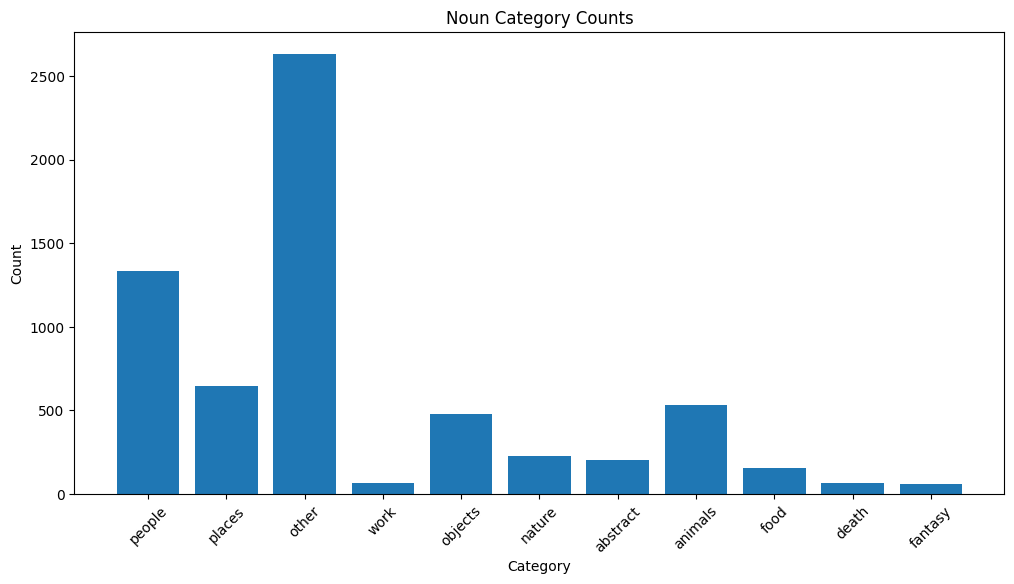

In [26]:
# Lets count the occurrences of each category
category_counts = Counter()
for col in ['category', 'category uncanny', 'category questions']:
    for categories in dataC1[col]:
        category_counts.update(categories)
print("Category counts:", category_counts)

#plotting the category counts
plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xticks(rotation=45)
plt.title('Noun Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


Comparing how often men occur, compared to women

In [27]:
# Women occurence compared to Men
women_words = {'woman', 'women', 'girl', 'girls', 'lady', 'ladies', 'daughter', 'daughters', 'sister', 'sisters'} #, 'mother', 'mothers'}
men_words = {'man', 'men', 'boy', 'boys', 'gentleman', 'gentlemen', 'son', 'sons', 'brother', 'brothers'}# 'father', 'fathers',

# Count occurrences of women and men words
women_count = dataC1['nouns'].apply(lambda nouns: sum(1 for noun in nouns if noun in women_words)).sum()
men_count = dataC1['nouns'].apply(lambda nouns: sum(1 for noun in nouns if noun in men_words)).sum()
             
print(f"Fraction of women-related words: {women_count / (women_count+men_count):.2%}")

Fraction of women-related words: 27.62%


I am now interested to make a new dataframe which contains all the comments with female words, and same for male words. I want to see what words appear the most in said captions.

In [28]:

# Sub dataframe with only entries that have women-related words
dataC_women = dataC1[
    dataC1['nouns'].apply(lambda nouns: any(noun in women_words for noun in nouns)) |
    dataC1['uncanny nouns'].apply(lambda nouns: any(noun in women_words for noun in nouns)) |
    dataC1['questions nouns'].apply(lambda nouns: any(noun in women_words for noun in nouns))
]
# Same for men
dataC_men = dataC1[
    dataC1['nouns'].apply(lambda nouns: any(noun in men_words for noun in nouns)) |
    dataC1['uncanny nouns'].apply(lambda nouns: any(noun in men_words for noun in nouns)) |
    dataC1['questions nouns'].apply(lambda nouns: any(noun in men_words for noun in nouns))
]


# Make a count of all nouns that follow women-related words
def count_following_nouns(df, gender_words):
    counter = Counter()
    for noun_list in df['nouns']:
        for i, noun in enumerate(noun_list[:-1]):
            if any(noun.startswith(g) for g in gender_words):
                next_noun = noun_list[i+1]
                counter[next_noun] += 1
    return counter

women_follow_counts = count_following_nouns(dataC_women, women_words)
men_follow_counts   = count_following_nouns(dataC_men, men_words)

# Make a count of all nouns that are before women-related words
def count_preceding_nouns(df, gender_words):
    counter = Counter()
    for noun_list in df['nouns']:
        for i, noun in enumerate(noun_list[1:], start=1):
            if noun in gender_words:
                prev_noun = noun_list[i-1]
                counter[prev_noun] += 1
    return counter

women_preceding_counts = count_preceding_nouns(dataC_women, women_words)
men_preceding_counts   = count_preceding_nouns(dataC_men, men_words)


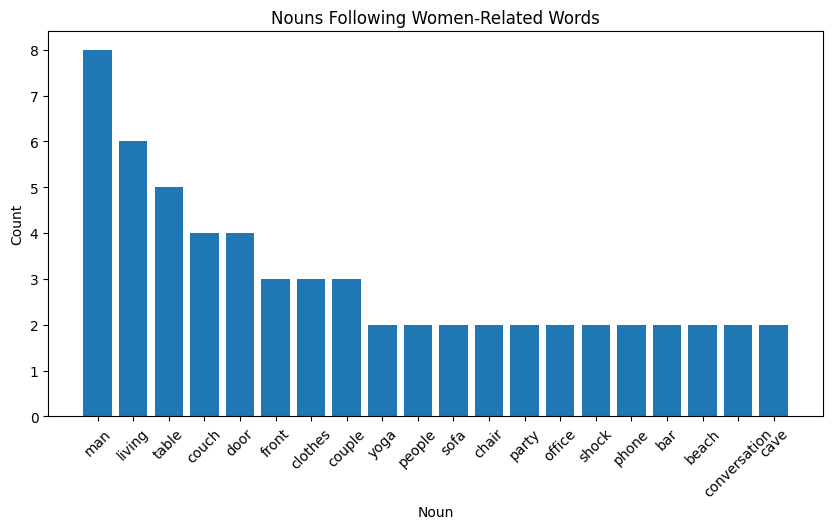

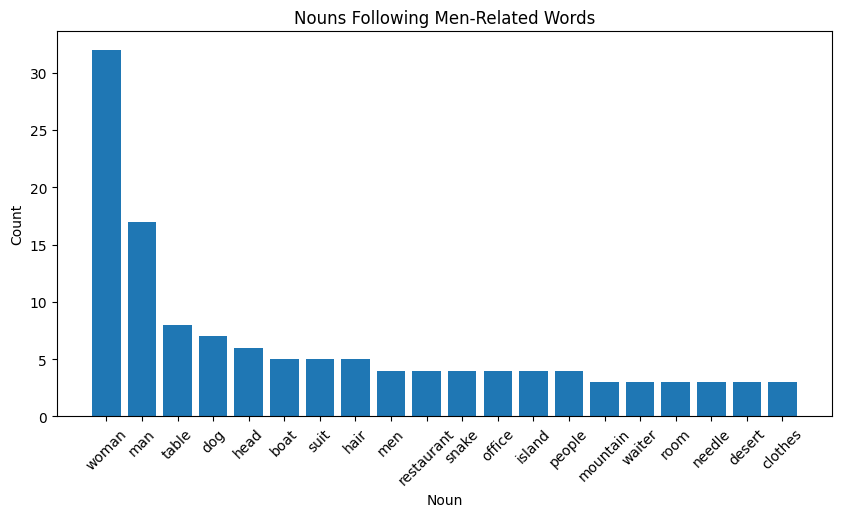

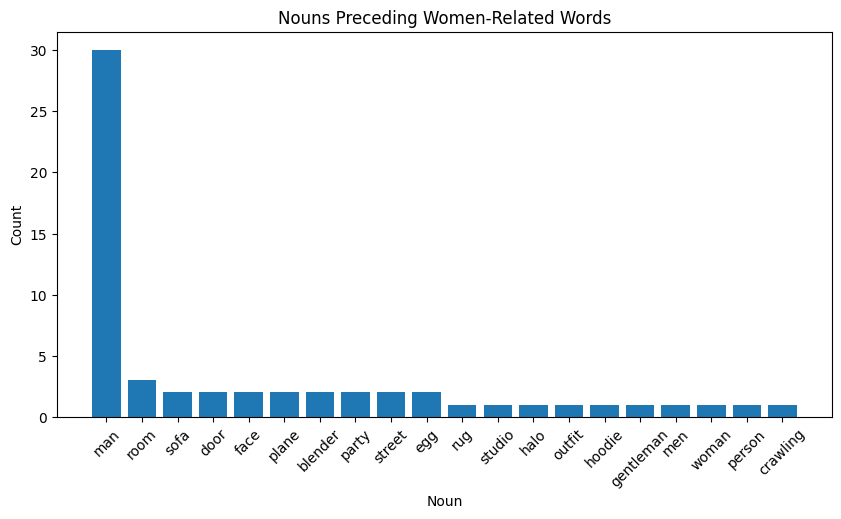

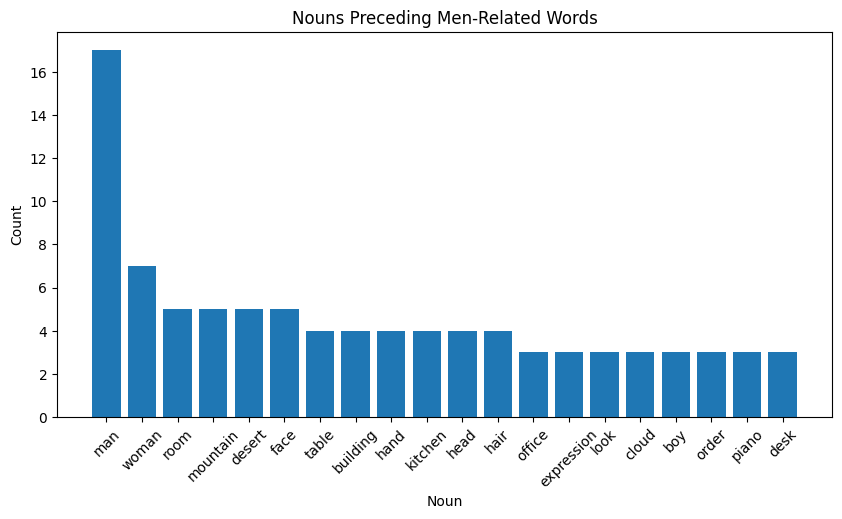

In [29]:
# Visualisation
def plot_following_nouns(counter, title):
    most_common = counter.most_common(20)
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Noun')
    plt.ylabel('Count')
    plt.show()
plot_following_nouns(women_follow_counts, 'Nouns Following Women-Related Words')
plot_following_nouns(men_follow_counts, 'Nouns Following Men-Related Words')
plot_following_nouns(women_preceding_counts, 'Nouns Preceding Women-Related Words')
plot_following_nouns(men_preceding_counts, 'Nouns Preceding Men-Related Words')

It would be interesting to look at adjectives attached to man and woman...

Lets look at women are distributed in the captions, how often they are mentioned and such. I will also try and look at what follows and precedes women. Do the same for men.
Maybe run a search for locations occuring tooo...

In [30]:
dataA3 = dataA2.copy()

# Gendered words
exclude_gender_words = women_words | men_words


def extract_nouns(tokens, pos_tags):
    """Return only nouns, excluding gender words."""
    return [
        t.lower()
        for t, p in zip(tokens, pos_tags)
        if p.startswith('N') and t.lower() not in exclude_gender_words
    ]

# Extract nouns for each DataFrame in dataA2
from nltk import pos_tag

for d in dataA2:
    def get_nouns_from_caption(caption):
        tokens = tokenizer.tokenize(caption.lower())
        pos_tags = pos_tag(tokens)
        return extract_nouns(tokens, [p for _, p in pos_tags])
    d['nouns'] = d['caption'].apply(get_nouns_from_caption)


# Gender-specific subframes
dataA3_women = [d[d['caption'].str.lower().apply(lambda text: any(w in text for w in women_words))] for d in dataA3]
dataA3_men   = [d[d['caption'].str.lower().apply(lambda text: any(w in text for w in men_words))] for d in dataA3]

# Exclude gender words from noun counts
all_nouns_women = [
    noun.lower()
    for d in dataA3_women
    for nouns in d['nouns']  # assumes each entry is list of nouns
    for noun in nouns
    if noun.lower() not in exclude_gender_words
]

word_counts_women = Counter(all_nouns_women)
print("Most common nouns in women-related captions (excluding gender words):")
print(word_counts_women.most_common(20))

# Exclude gender words from noun counts
all_nouns_men = [
    noun.lower()
    for d in dataA3_men
    for nouns in d['nouns']
    for noun in nouns
    if noun.lower() not in exclude_gender_words
]

word_counts_men = Counter(all_nouns_men)
print("Most common nouns in men-related captions (excluding gender words):")
print(word_counts_men.most_common(20))

KeyboardInterrupt: 

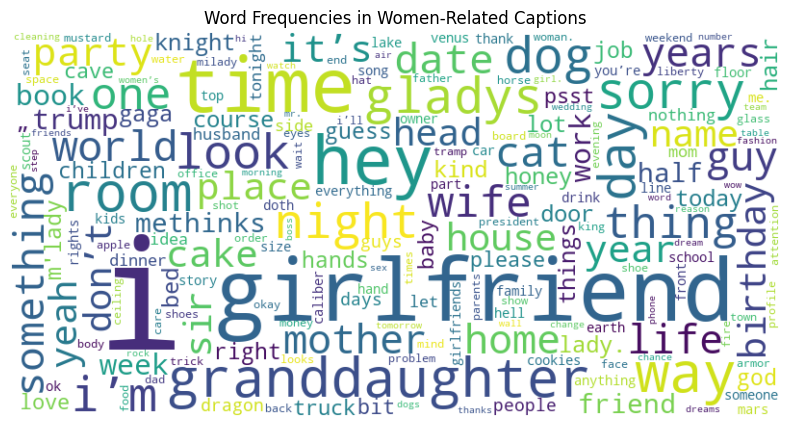

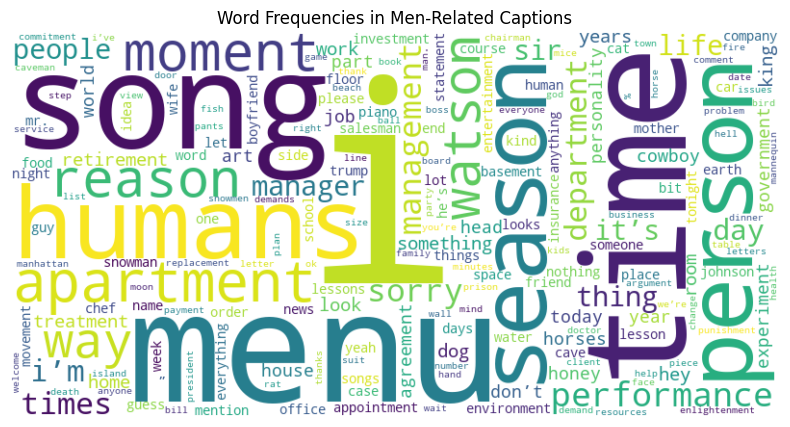

In [ ]:
# Visualisation of word frequencies using wordcloud
wordcloud_women = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_women)
plt.figure(figsize=(10, 5))
plt.title('Word Frequencies in Women-Related Captions')
plt.imshow(wordcloud_women, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud_men = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_men)
plt.figure(figsize=(10, 5))
plt.title('Word Frequencies in Men-Related Captions')
plt.imshow(wordcloud_men, interpolation='bilinear')
plt.axis('off')
plt.show()

# Topic 3 –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

<p style="text-align: center;"><em></em></p>

We will now look at my third topic.

In [33]:
themes = {
    "politics": {
        "president","presidents","congress","senate","senator","parliament","minister","ministries",
        "campaign","vote","voting","election","elections","law","laws","politician","politicians",
        "government","governor","mayor","candidate","debate","policy","policies","democracy","republic",
        "dictator","dictatorship","regime","diplomat","ambassador","bureaucrat","bureaucracy",
        "constitution","justice","rights","bill","parliament","party","republican","democrat",
        "campaigning","voter","voters","ballot","politics","political","press","scandal", 'Trump', 
        'Obama', 'Biden', 'Clinton', 'Bush', 'MAGA'
    },

    "religion": {
        "god","gods","church","temple","mosque","synagogue","heaven","hell","paradise","afterlife",
        "priest","pastor","bishop","cardinal","minister","rabbi","monk","nun","holy","sacred","divine",
        "bible","quran","torah","scripture","faith","belief","worship","pray","prayer","cross","halo",
        "angel","angels","saint","saints","miracle","religion","religious","soul","spirit","spiritual",
        "devil","demon","demons","sin","sinner","sins","sermon","altar","mass","moses","adam","eden",
        "creation","baptism","heavenly"
    },

    "animals": {
        "dog","dogs","cat","cats","fish","fishes","bird","birds","horse","horses","cow","cows","pig","pigs",
        "sheep","lion","lions","bear","bears","tiger","tigers","monkey","monkeys","donkey","donkeys",
        "duck","ducks","chicken","chickens","goose","geese","snake","snakes","rabbit","rabbits",
        "mouse","mice","rat","rats","elephant","elephants","giraffe","giraffes","wolf","wolves",
        "shark","sharks","whale","whales","doggie","kitty","pet","pets","animal","animals","creature",
        "creatures","zoo","farm","barn","pony","beast","wildlife","species","nature"
    },

    "relationships": {
        "husband","wife","wives","marriage","wedding","divorce","relationship","relationships",
        "love","lover","lovers","couple","couples","boyfriend","girlfriend","partner","partners",
        "romance","date","dating","flirt","flirting","family","families","child","children","kid","kids",
        "parent","parents","mother","mom","mommy","father","dad","daddy","son","daughter","brother",
        "sister","siblings","aunt","uncle","grandmother","grandfather","friend","friends","roommate",
        "neighbor","neighbors","bride","groom","affair","spouse","fiancé","relationship","bond"
    },

    "work": {
        "office","offices","boss","bosses","job","jobs","career","careers","meeting","meetings","employee",
        "employees","employer","manager","managers","lawyer","lawyers","doctor","doctors","client","clients",
        "business","businesses","company","companies","corporate","corporation","job","employment","firm",
        "agency","startup","entrepreneur","freelancer","colleague","coworker","coworkers","supervisor",
        "assistant","intern","workplace","workplaces","factory","factories","office","meeting","worker",
        "workers","professional","professionals","occupation","promotion","deadline","resume","workload",
        "paycheck","salary","conference","team","project","presentation","report"
    },

    "technology": {
        "computer","computers","laptop","laptops","phone","phones","cellphone","smartphone","tv","television",
        "tablet","device","devices","robot","robots","machine","machines","drone","drones","camera","cameras",
        "screen","screens","internet","wifi","app","apps","application","applications","software","hardware",
        "ai","algorithm","cyborg","virtual","online","digital","email","emails","printer","keyboard","mouse",
        "remote","console","video","game","gaming","programmer","server","tech","technology","technological"
    },

    "food": {
        "restaurant","restaurants","bar","bars","cafe","cafes","pub","diner","coffee","tea","latte","espresso",
        "cake","cakes","pizza","pizzas","burger","burgers","sandwich","sandwiches","dinner","lunch","breakfast",
        "kitchen","cook","cooking","chef","baker","oven","fridge","refrigerator","wine","beer","champagne",
        "cocktail","drink","drinks","alcohol","meal","meals","menu","table","tables","plate","plates","fork",
        "spoon","knife","cup","cups","glass","glasses","snack","dessert","icecream","donut","bread","toast",
        "meat","beef","chicken","fish","seafood","fruit","fruits","vegetable","vegetables","soup","salad",
        "food","groceries","market","kitchenware"
    },

    "death": {
        "coffin","coffins","grave","graves","cemetery","cemeteries","tomb","tombs","reaper","grim","skeleton",
        "skull","ghost","ghosts","corpse","corpses","death","dying","dead","funeral","mourning","afterlife",
        "heaven","hell","spirit","souls","haunted","zombie","zombies","vampire","vampires","burial","ashes",
        "gravestone","undertaker","casket","mortuary","graveyard","angel","demise","macabre"
    }
}

dataA4 = dataA.copy()

# I found this that could be useful
from nltk.corpus import wordnet as wn
#nltk.download('wordnet')

def expand_with_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower().replace('_', ' '))
    return synonyms
# Expand themes with synonyms
for theme, words in themes.items():
    expanded_words = set()
    for word in words:
        expanded_words.update(expand_with_synonyms(word))
    themes[theme] = expanded_words

print("Expanded themes with synonyms:")
for theme, words in themes.items():
    print(f"{theme}: {', '.join(words)}")

Expanded themes with synonyms:
politics: us constitution, sex act, intercourse, trump card, prospect, balloting, fundamental law, bank bill, sexual congress, chairperson, republican, city manager, george bush, political sympathies, printing press, dictator, federal reserve note, argue, law of nature, hilary clinton, government note, clinton, stalinism, practice of law, police, legal philosophy, sevens, caesarism, shogunate, scrub, coitus, agitate, banknote, jurist, urge on, carnal knowledge, military campaign, best, absolutism, pol, crush, parliament, diplomatist, governance, notice, public debate, laws, united states president, deliberate, weigh, constitution, movement, jam, hunting expedition, invoice, campaign, insistency, diplomatic minister, republican river, note, outflank, crusade, right, argument, party, majority rule, urge, mayor, commonwealth, bureaucrat, bill, press out, political campaign, candidate, scoop, makeup, united states congress, contract, regulator, torah, democra

So now we have access to a large dictionary which will allow us to categorise the nouns that occur in the captions

Overall theme counts: Counter({'death': 283940, 'work': 270072, 'relationships': 266970, 'food': 254069, 'religion': 240782, 'animals': 229371, 'politics': 164699, 'technology': 121923})


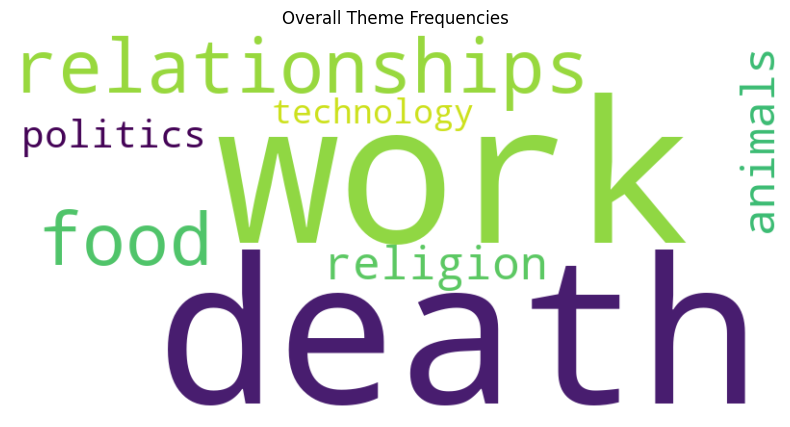

In [36]:
# Count occurrences of theme words in captions
def count_theme_words(tokens):
    theme_count = {theme: 0 for theme in themes}
    for token in tokens:
        for theme, words in themes.items():
            if token in words:
                theme_count[theme] += 1
    return theme_count

for d in dataA4:
    d['theme_counts'] = d['tokens'].apply(count_theme_words)
# Aggregate theme counts across all captions
all_theme_counts = Counter()
for d in dataA4:
    for counts in d['theme_counts']:
        all_theme_counts.update(counts)
print("Overall theme counts:", all_theme_counts)
# Visualisation of theme frequencies using wordcloud
wordcloud_themes = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_theme_counts)
plt.figure(figsize=(10, 5))
plt.title('Overall Theme Frequencies')
plt.imshow(wordcloud_themes, interpolation='bilinear')
plt.axis('off')
plt.show()


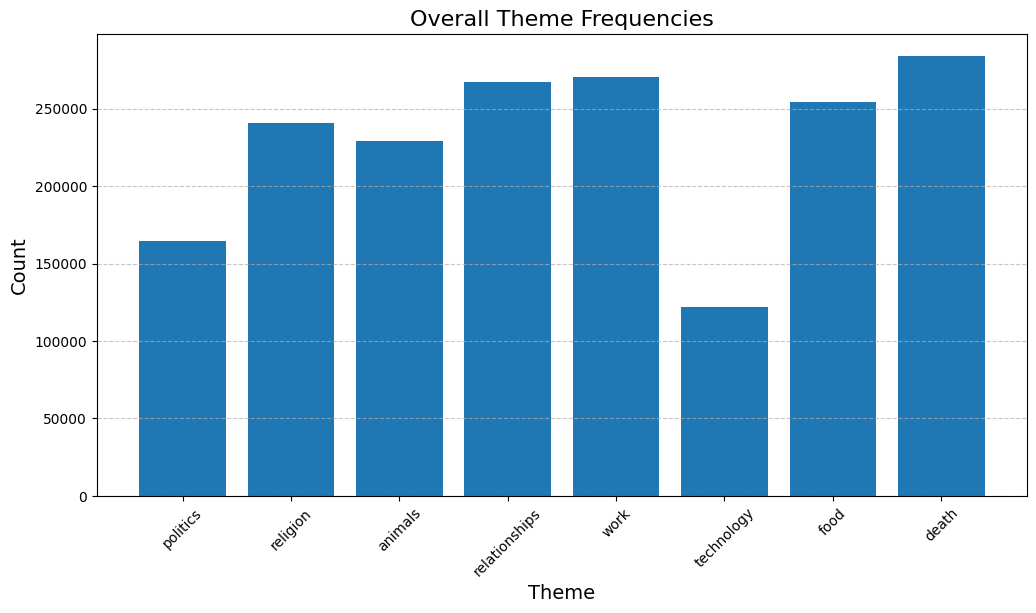

In [35]:
#Also plot a bar chart of theme frequencies
plt.figure(figsize=(12, 6))
plt.bar(all_theme_counts.keys(), all_theme_counts.values())
plt.xticks(rotation=45)
plt.title('Overall Theme Frequencies', fontsize = 16)
plt.xlabel('Theme', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.grid(which='major', axis='y', linestyle='--', alpha=0.7)
plt.show()

We could now visualise:
 - what words within a topic occur most often 
 - what topics occur in the top comments compared to the worst performing jokes.

Most common words in theme 'politics': [('right', 36730), ('best', 13800), ('trump', 10130), ('run', 7705), ('party', 6367)]
Most common words in theme 'religion': [('look', 40345), ('feel', 24778), ('life', 18423), ('people', 15905), ('world', 14564)]
Most common words in theme 'animals': [('dog', 14574), ('guy', 13281), ('fish', 11313), ('cat', 9670), ('wear', 7588)]
Most common words in theme 'relationships': [('home', 23442), ('honey', 16324), ('love', 14907), ('house', 13230), ('play', 13046)]
Most common words in theme 'work': [('help', 13914), ('house', 13230), ('play', 13046), ('place', 11956), ('job', 11606)]
Most common words in theme 'technology': [('call', 23736), ('play', 13046), ('car', 8032), ('game', 7278), ('outside', 4587)]
Most common words in theme 'food': [('home', 23442), ('stop', 17517), ('fish', 11313), ('food', 9172), ('table', 8920)]
Most common words in theme 'death': [('look', 40345), ('sorry', 35736), ('last', 29407), ('feel', 24778), ('life', 18423)]


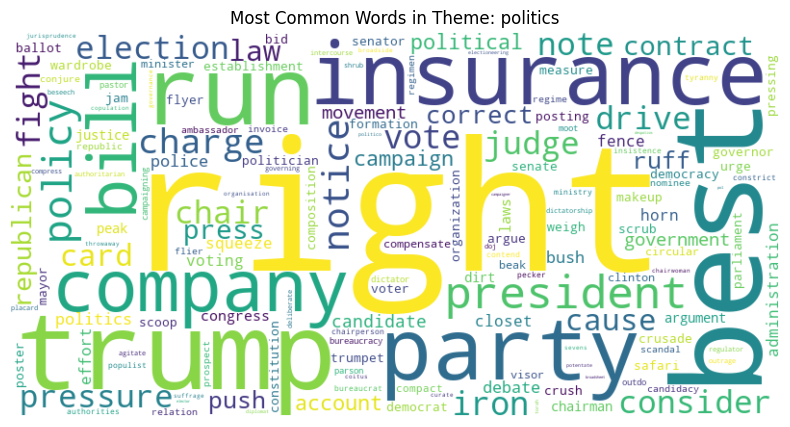

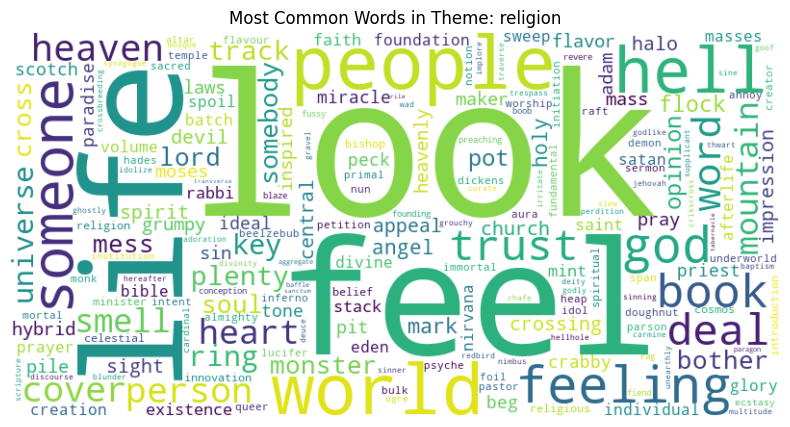

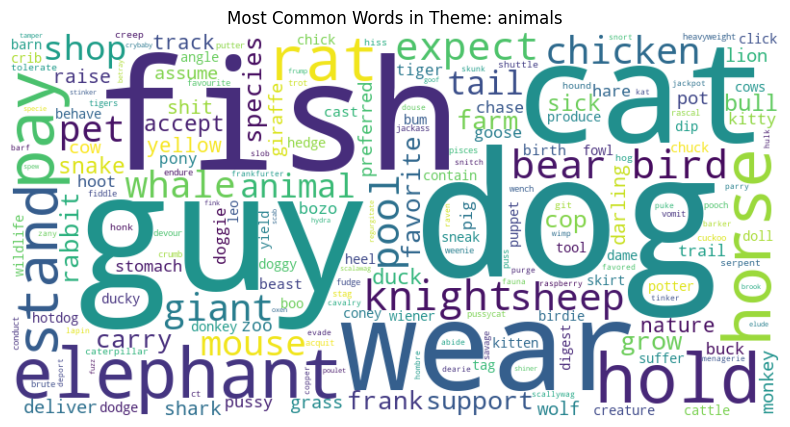

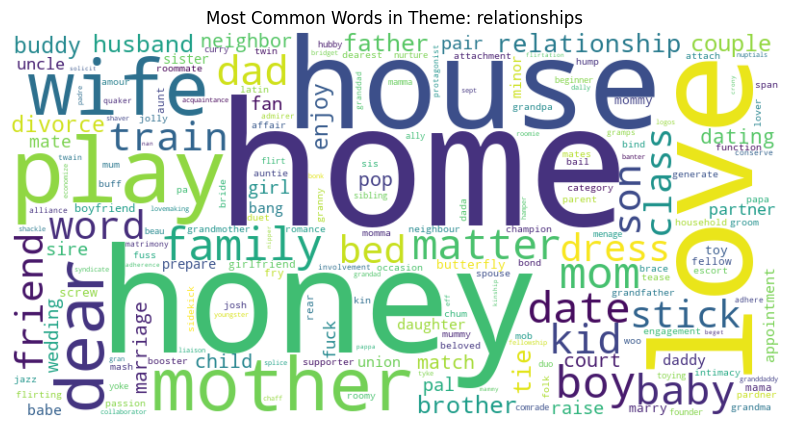

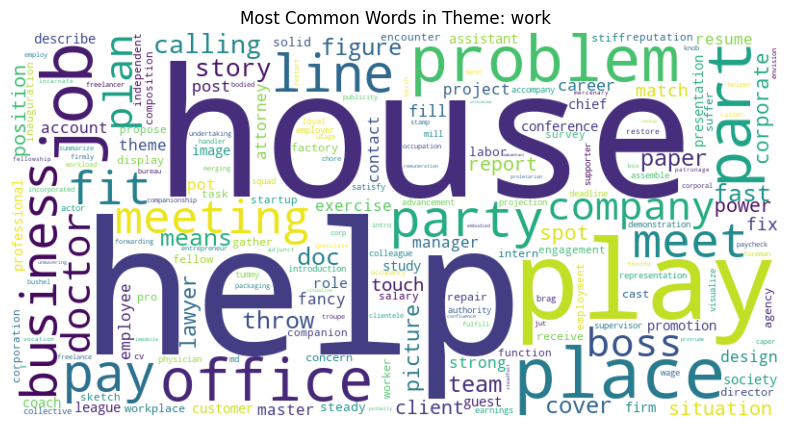

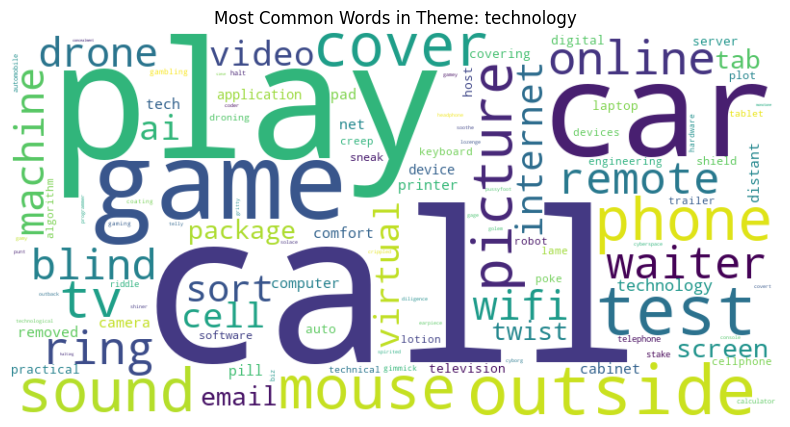

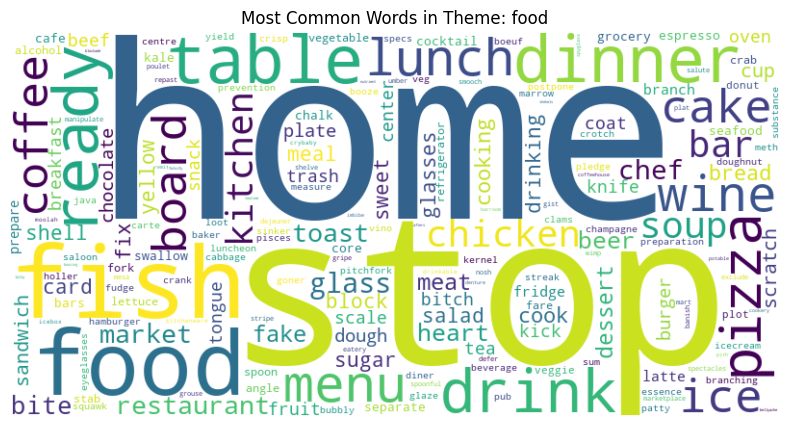

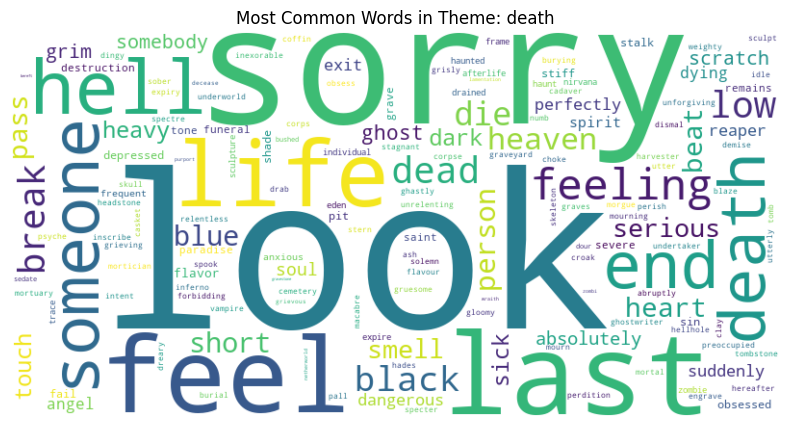

In [37]:
# what words are most common in each theme? take the 5 most common words in each theme
theme_word_counts = {theme: Counter() for theme in themes}
for d in dataA4:
    for tokens, counts in zip(d['tokens'], d['theme_counts']):
        for token in tokens:
            for theme, count in counts.items():
                if count > 0 and token in themes[theme]:
                    theme_word_counts[theme][token] += 1
for theme, counter in theme_word_counts.items():
    print(f"Most common words in theme '{theme}': {counter.most_common(5)}")
# Visualise the most common words in each theme using wordclouds
for theme, counter in theme_word_counts.items():
    if counter:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
        plt.figure(figsize=(10, 5))
        plt.title(f'Most Common Words in Theme: {theme}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
        

Theme counts in top 100 comments: Counter({'death': 4600, 'work': 4592, 'relationships': 4323, 'religion': 3883, 'food': 3780, 'animals': 3480, 'politics': 2839, 'technology': 2025})


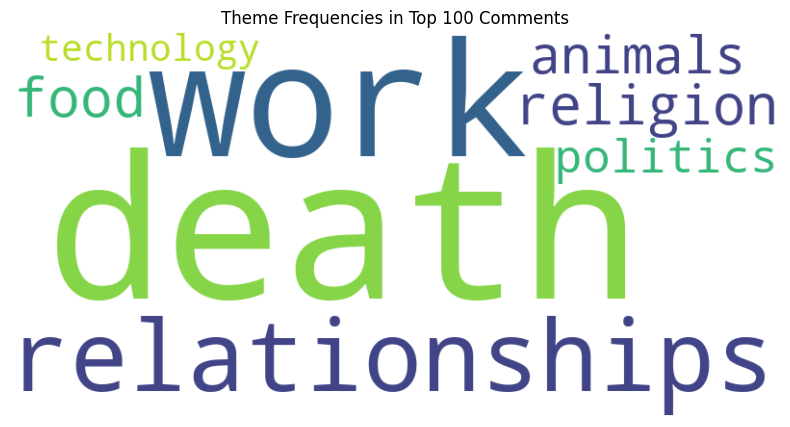

Theme counts in bottom 1000 comments: Counter({'relationships': 5291, 'death': 5061, 'work': 5040, 'food': 4989, 'animals': 4707, 'religion': 4575, 'politics': 3067, 'technology': 2365})


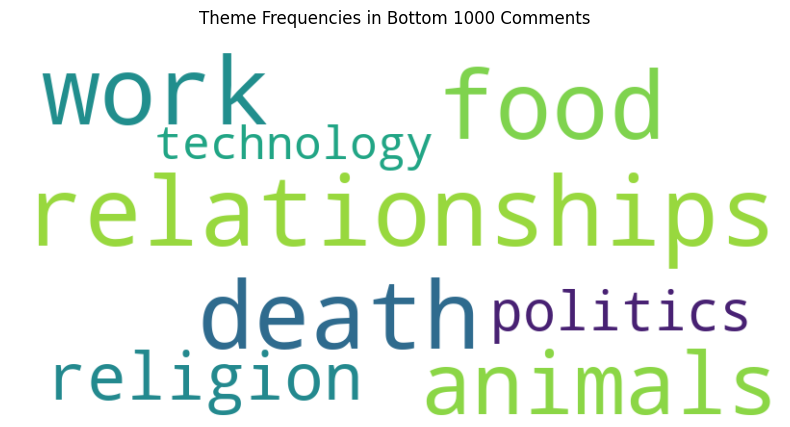

In [41]:
# Let us look at themes count in the top 100 comments, based on funniness score
top_100_theme_counts = Counter()
for d in dataA4:
    top_100 = d.nlargest(100, 'funniness_score')
    for counts in top_100['theme_counts']:
        top_100_theme_counts.update(counts)
print("Theme counts in top 100 comments:", top_100_theme_counts)
# Visualisation of theme frequencies in top 100 comments using wordcloud
wordcloud_top_themes = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_100_theme_counts)
plt.figure(figsize=(10, 5))
plt.title('Theme Frequencies in Top 100 Comments')
plt.imshow(wordcloud_top_themes, interpolation='bilinear')
plt.axis('off')
plt.show()

# in the least funny 100 comments
bottom_100_theme_counts = Counter()
for d in dataA4:
    bottom_100 = d.nsmallest(100, 'funniness_score')
    for counts in bottom_100['theme_counts']:
        bottom_100_theme_counts.update(counts)
print("Theme counts in bottom 100 comments:", bottom_100_theme_counts)

# Visualisation of theme frequencies in bottom 100 comments using wordcloud
wordcloud_bottom_themes = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bottom_100_theme_counts)
plt.figure(figsize=(10, 5))
plt.title('Theme Frequencies in Bottom 100 Comments')
plt.imshow(wordcloud_bottom_themes, interpolation='bilinear')
plt.axis('off')
plt.show()

# Topic 4 –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
What about taboo topics?

In [43]:
taboo_themes = {
    "violence": {
        "gun","guns","weapon","weapons","knife","knives","sword","fight","fights",
        "murder","kill","killing","blood","war","wars","battle","battles",
        "attack","attacks","soldier","soldiers","army","violence","violent",
        "crime","criminal","shoot","shooting","bomb","explosion","explode",
        "punch","hit","stab","bullet","grenade","missile","weaponry"
    },

    "death": {
        "death","dead","dying","coffin","coffins","grave","graves","cemetery","cemeteries",
        "skeleton","corpse","corpses","funeral","funerals","zombie","zombies",
        "ghost","ghosts","reaper","tomb","tombs","graveyard","spirit","spirits",
        "afterlife","undertaker","burial","ashes","casket","gravestone","obituary"
    },

    "sex": {
        "sex","sexual","naked","nude","kiss","kissing","lover","lovers","relationship",
        "relationships","affair","affairs","flirt","flirting","bed","bedroom","romance",
        "erotic","date","dating","couple","couples","wife","wives","husband","mistress",
        "seduce","seduction","intimacy","intimate","passion","passionate","love","lust",
        "sexuality","fetish","orgasm","affection","girlfriend","boyfriend"
    },

    "religion": {
        "god","gods","church","temple","mosque","synagogue","heaven","hell","priest",
        "angel","angels","devil","demons","bible","moses","sin","sins","holy","saint",
        "saints","miracle","faith","religion","religious","spirit","spirits",
        "afterlife","altar","cross","soul","souls","sacred","divine","clergy",
        "sermon","monk","nun","pastor","bishop","rabbi"
    },

    "suicide": {
        "suicide","suicidal","kill myself","take my life","end my life","end it all",
        "hang","hanging","jump","jumping","bridge","rope","noose","pills","overdose",
        "slit","wrist","commit suicide","self harm","self-harm","gun to head",
        "put a gun","drink poison","falling off","cliff","ledge"
    }
}

# Expanding taboo themes with synonyms
def expand_with_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower().replace('_', ' '))
    return synonyms
# Expand themes with synonyms
for theme, words in taboo_themes.items():
    expanded_words = set()
    for word in words:
        expanded_words.update(expand_with_synonyms(word))
    taboo_themes[theme] = expanded_words

print("Expanded themes with synonyms:")
for theme, words in taboo_themes.items():
    print(f"{theme}: {', '.join(words)}")


Expanded themes with synonyms:
violence: dash, hit man, burgeon forth, gun for hire, fool, jab, pang, drink down, projectile, parentage, struggle, lineage, vote down, ground forces, down, pullulate, collision, pip, set on, dart, flush it, score, dig, fritter away, scoot, weapon system, smasher, grease-gun, inject, agitate, accelerator, vote out, remove, deplorable, onrush, oppose, steel, pour down, gas, condemnable, shooter, hired gun, belt down, rip, assail, thrust, set off, germinate, crook, turkey, fritter, rakehell, grenade, campaign, origin, competitiveness, gun, torpedo, crusade, combat, detonate, triggerman, flash, sidesplitting, killing, flack, break loose, gain, artillery, slug, weapons system, explosion, fastball, film, army, force, blood, vehemence, bullet train, rack up, mangle, criminal offense, crime, weapon, buck, fail, stumble, dud, pop, plan of attack, approach, united states army, crimson, fierceness, line of descent, malefactor, shoot, bloodline, flunk, bolt down, to

In [47]:
# Count occurrences of theme words in captions
def count_taboo_theme_words(tokens):
    theme_count = {theme: 0 for theme in taboo_themes}
    for token in tokens:
        for theme, words in taboo_themes.items():
            if token in words:
                theme_count[theme] += 1
    return theme_count
for d in dataA4:
    d['taboo_theme_counts'] = d['tokens'].apply(count_taboo_theme_words)
# Aggregate taboo theme counts across all captions
all_taboo_theme_counts = Counter()
for d in dataA4:
    for counts in d['taboo_theme_counts']:
        all_taboo_theme_counts.update(counts)
print("Overall taboo theme counts:", all_taboo_theme_counts)



Overall taboo theme counts: Counter({'death': 193367, 'religion': 179048, 'sex': 147869, 'violence': 109977, 'suicide': 45067})


AttributeError: 'int' object has no attribute 'items'

To do a temporal analysis, we need to fill with dates the missing images. This will be done by doing a linear interpolation essentially.

In [54]:
# Fill in missing dates
from datetime import timedelta
dataC2 = dataC1.copy()

filled_dates = dataC2['date'].copy()
known_idx = filled_dates.dropna().index


if len(known_idx) > 0:
    # filling all the missing dates before the first known date
    first_date = filled_dates[known_idx[0]]
    for i in range(known_idx[0], -1, -1):
        first_date -= timedelta(days=7)
        filled_dates.iloc[i] = first_date
    # filling in between known dates
    for i in range(len(known_idx) - 1):
        start_idx = known_idx[i]
        end_idx = known_idx[i + 1]
        start_date = filled_dates[start_idx]
        end_date = filled_dates[end_idx]
        
        delta_days = (end_date - start_date).days
        num_missing = end_idx - start_idx - 1
        if num_missing > 0:
            avg_days = delta_days // (num_missing + 1)
            print(f"Filling {num_missing} missing dates between index {start_idx} and {end_idx} with avg_days={avg_days}")
            for j in range(1, num_missing + 1):
                filled_dates.iloc[start_idx + j] = start_date + timedelta(days=float(avg_days * j))
    # filling all the missing dates after the last known date
    last_date = filled_dates[known_idx[-1]]
    for i in range(known_idx[-1] + 1, len(filled_dates)):
        last_date += timedelta(days=7)
        filled_dates.iloc[i] = last_date

dataC2['filled_date'] = filled_dates
print("Filled missing dates.")
dataC2['filled_date']


Filling 35 missing dates between index 74 and 110 with avg_days=7
Filling 1 missing dates between index 167 and 169 with avg_days=7
Filling 1 missing dates between index 183 and 185 with avg_days=10
Filling 1 missing dates between index 236 and 238 with avg_days=7
Filled missing dates.


0     2016-02-29
1     2016-03-07
2     2016-03-14
3     2016-03-27
4     2016-04-03
         ...    
379   2024-03-04
380   2024-03-11
381   2024-03-18
382   2024-03-25
383   2024-04-01
Name: filled_date, Length: 384, dtype: datetime64[ns]

We can now count the temporal evolution of themes as defined above.

In [57]:
# temporal evolution of theme counts
#by using the dates in dataC2['filled_date'], we can add a date column to dataA4 based on matching the index
for i, d in enumerate(dataA4):
    if i < len(dataC2):
        d['date'] = dataC2.loc[i, 'filled_date']
print("Added date column to dataA4 based on dataC2 filled dates.")

Added date column to dataA4 based on dataC2 filled dates.
                                                caption      mean  precision  \
rank                                                                           
0             I'm a congressman--obstruction is my job.  1.913043   0.094022   
1     I'm what they mean when they say, 'The middle ...  1.842105   0.191381   
2                     Does this suit make me look flat?  1.711111   0.112915   
3       When the right woman comes along, I'll know it.  1.625000   0.116657   
4     I used to lie in the gutter, but then I quit d...  1.617647   0.133610   

      votes  not_funny  somewhat_funny  funny  funniness_score  \
rank                                                             
0        69         24              27     18         0.199189   
1        19          8               6      5         0.094504   
2        45         21              16      8        -0.105736   
3        32         15              14      3      

In [69]:
# Count apparition of themes over time
# Initialise Counters for both metrics
theme_time_series_votes = {theme: Counter() for theme in themes} # normalised by votes
theme_time_series_captions = {theme: Counter() for theme in themes} # normalised by captions

# Aggregate per contest
for d in dataA4:
    # Each contest dataframe 'd' has one unique date
    date = d['date'].iloc[0] if not d['date'].isna().all() else None
    if pd.notna(date):
        # Extract contest level totals from dataA
        total_votes = d['votes'].sum() if 'votes' in d.columns else 1
        total_captions = len(d)

        # Sum all caption level theme counts into one Counter
        total_counts = sum((Counter(x) for x in d['theme_counts']), Counter())

        # Add to counters, normalised by votes and captions
        for theme, count in total_counts.items():
            if count > 0:
                theme_time_series_votes[theme][date] += count / total_votes
                theme_time_series_captions[theme][date] += count / total_captions

# Convert to DataFrames for each theme
theme_time_dfs = {}
for theme in themes:
    df_votes = (
        pd.DataFrame.from_dict(theme_time_series_votes[theme], orient='index', columns=['count_per_vote'])
        .reset_index().rename(columns={'index': 'date'})
    )
    df_captions = (
        pd.DataFrame.from_dict(theme_time_series_captions[theme], orient='index', columns=['count_per_caption'])
        .reset_index().rename(columns={'index': 'date'})
    )
    # Merge and sort
    df = pd.merge(df_votes, df_captions, on='date', how='outer').sort_values('date')
    theme_time_dfs[theme] = df

# --- 4. Example plot
example_theme = 'politics'
df = theme_time_dfs[example_theme]



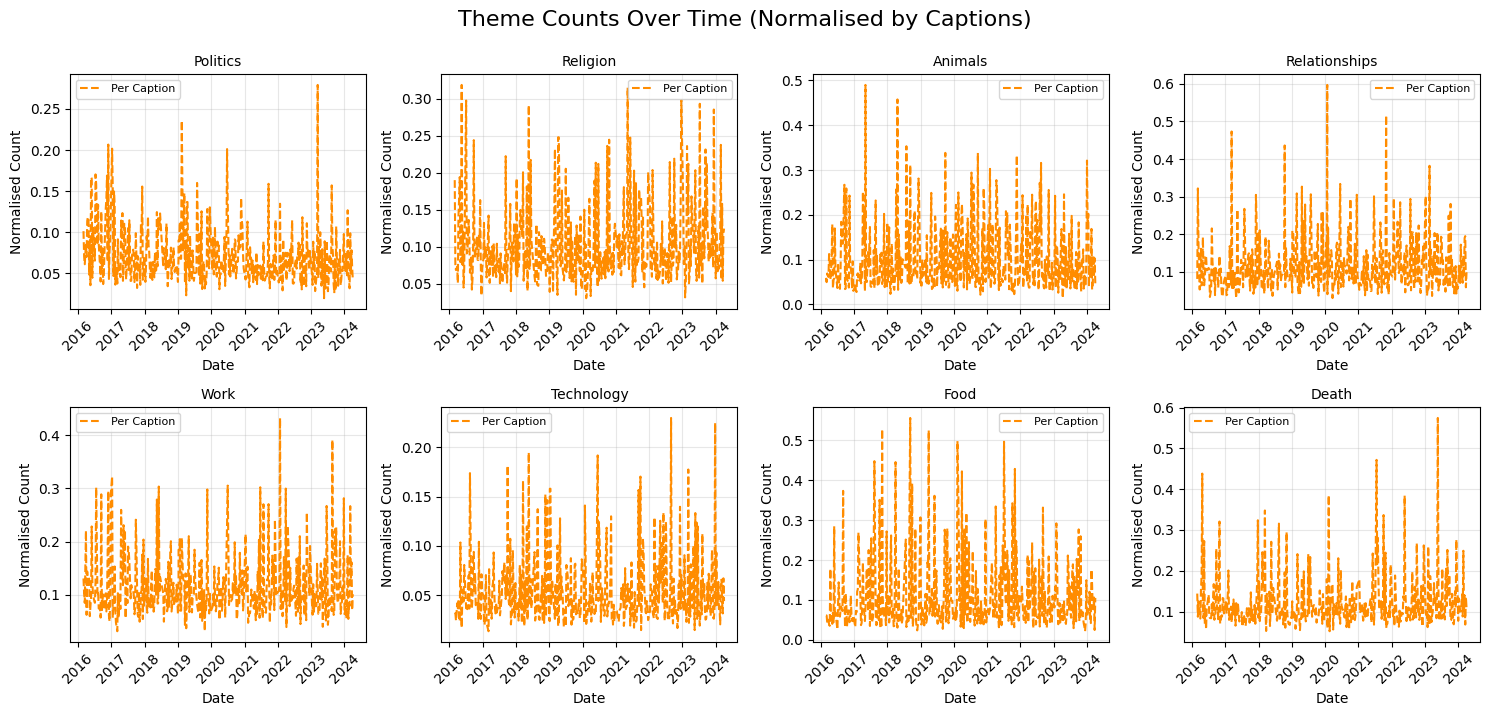

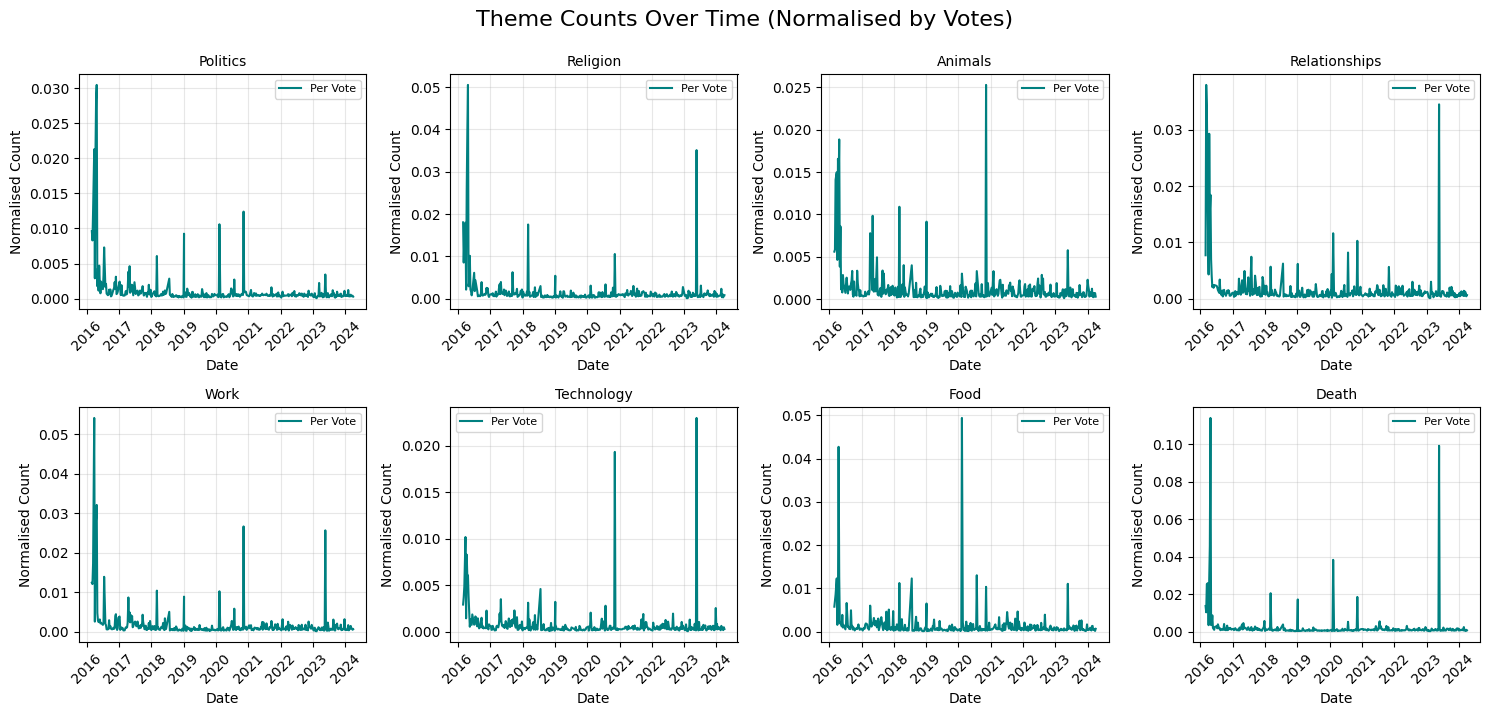

In [71]:
plt.figure(figsize=(15, 10))

for i, (theme, df) in enumerate(theme_time_dfs.items(), 1):
    plt.subplot(3, 4, i)
    
    plt.plot(df['date'], df['count_per_caption'], label='Per Caption', color='darkorange', linestyle='--')
    plt.title(theme.capitalize(), fontsize=10)
    plt.xlabel('Date')
    plt.ylabel('Normalised Count')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for main title

plt.suptitle('Theme Counts Over Time (Normalised by Captions)', fontsize=16)
plt.show()

plt.figure(figsize=(15, 10))
for i, (theme, df) in enumerate(theme_time_dfs.items(), 1):
    plt.subplot(3, 4, i)
    
    plt.plot(df['date'], df['count_per_vote'], label='Per Vote', color='teal', linestyle='-')
    plt.title(theme.capitalize(), fontsize=10)
    plt.xlabel('Date')
    plt.ylabel('Normalised Count')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for main title
plt.suptitle('Theme Counts Over Time (Normalised by Votes)', fontsize=16)
plt.show()

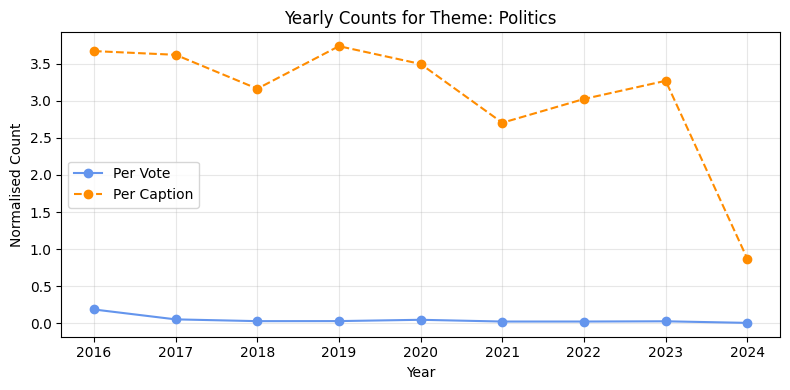

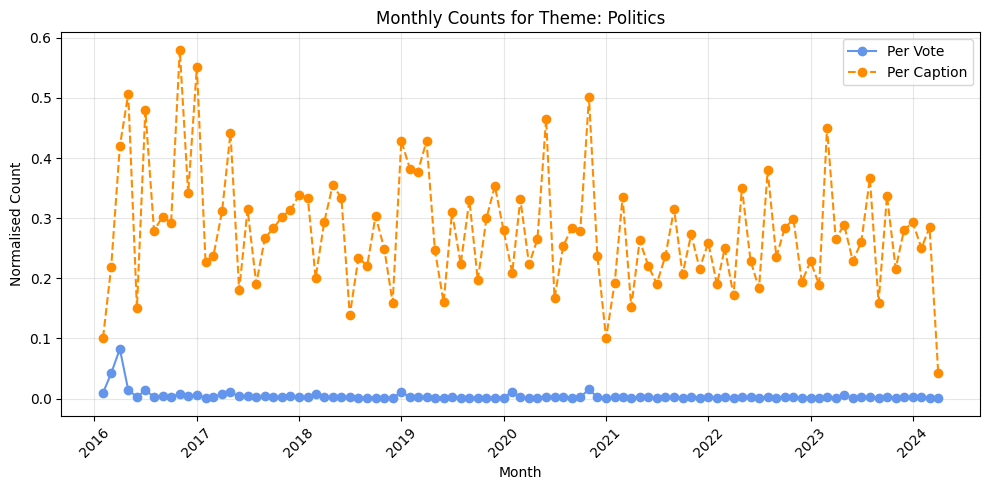

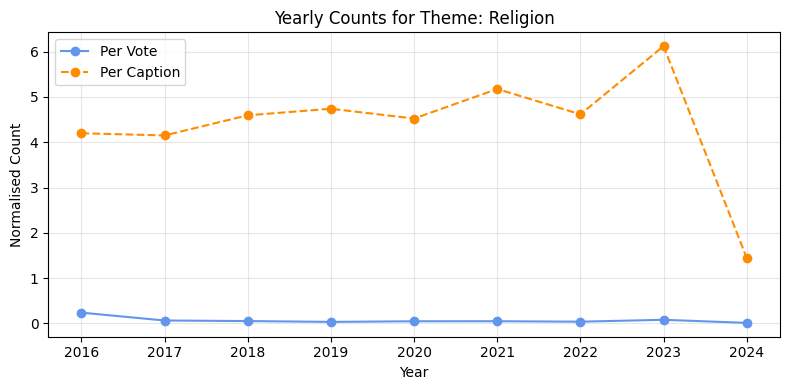

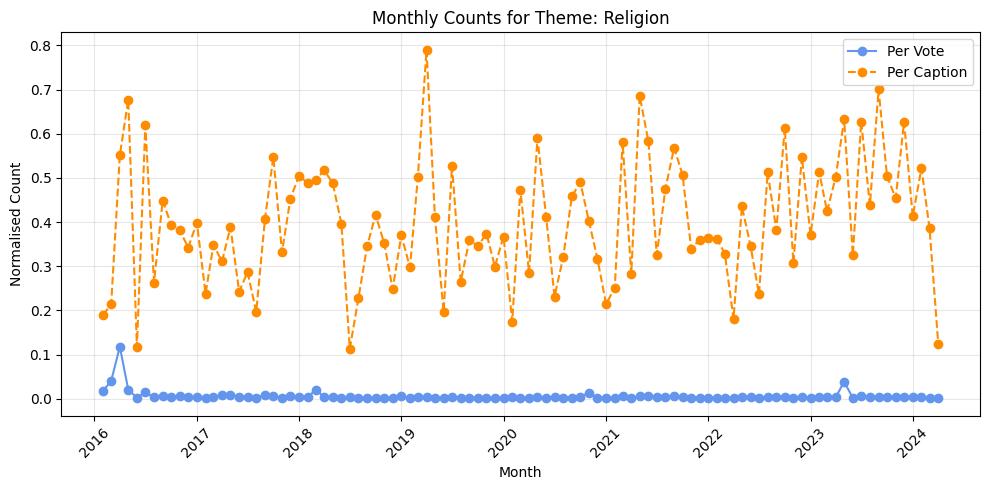

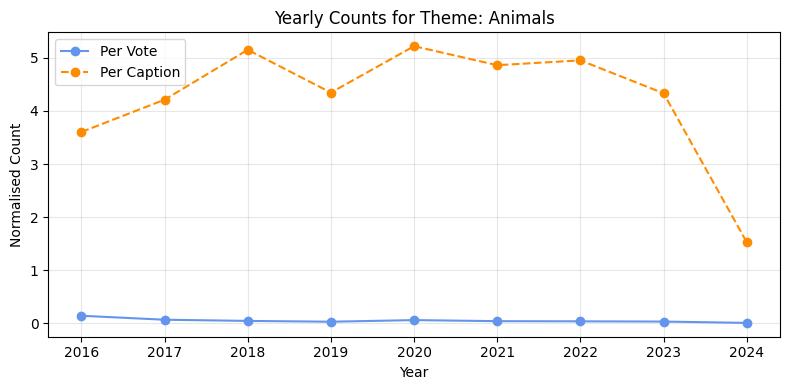

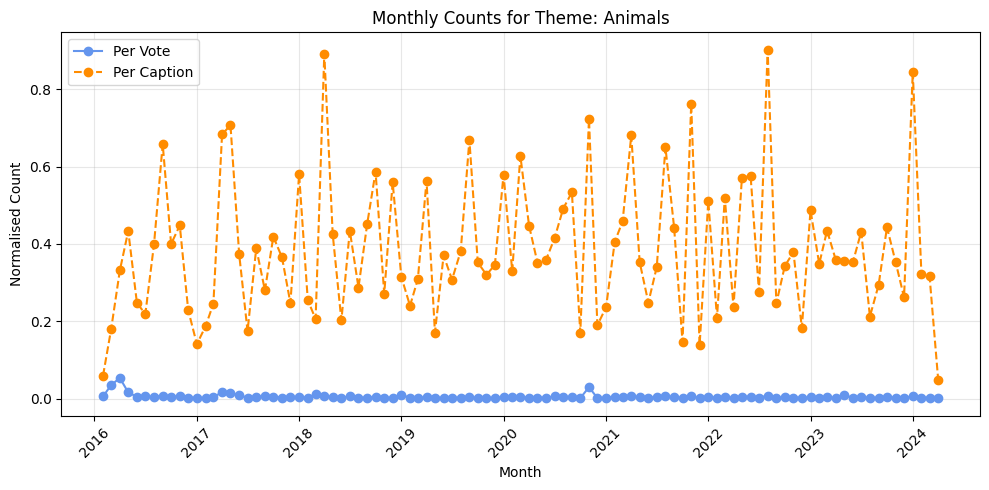

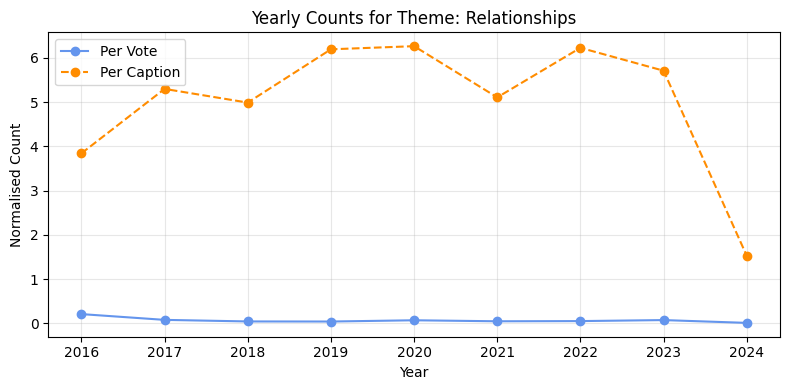

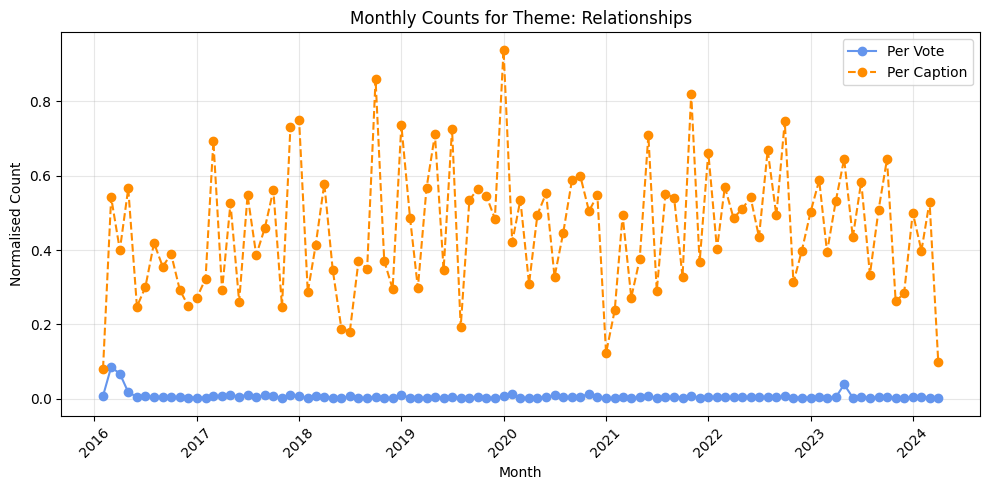

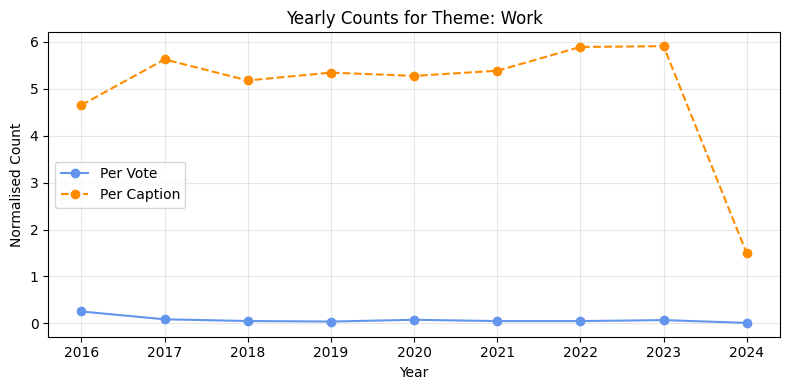

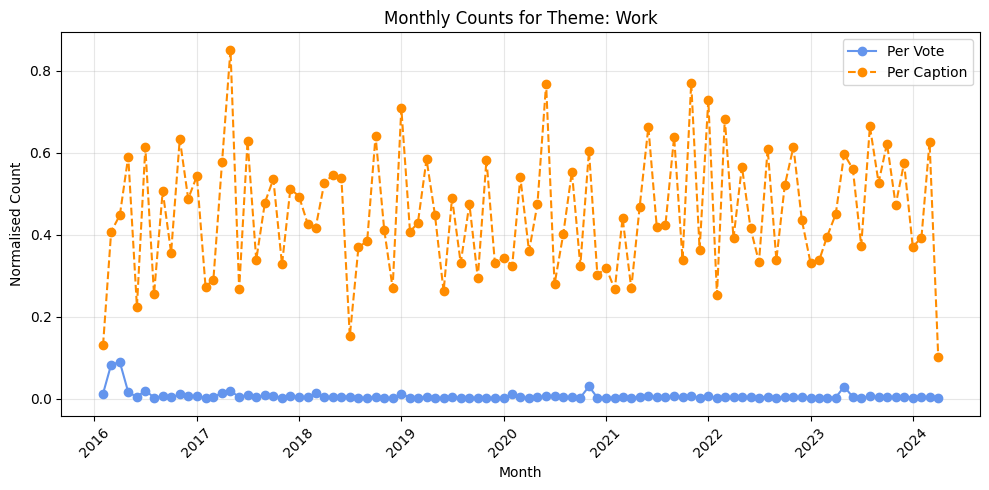

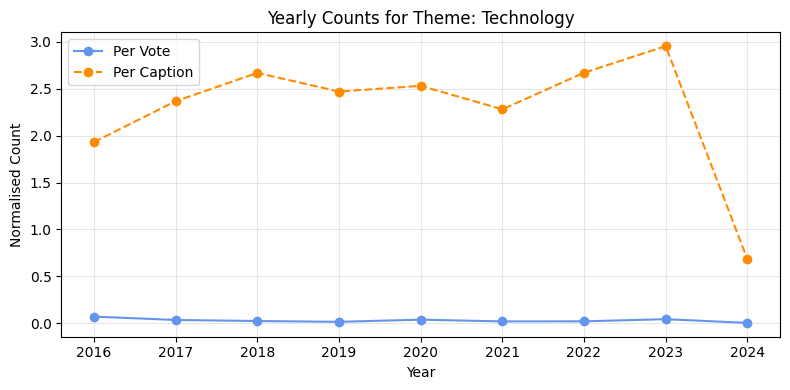

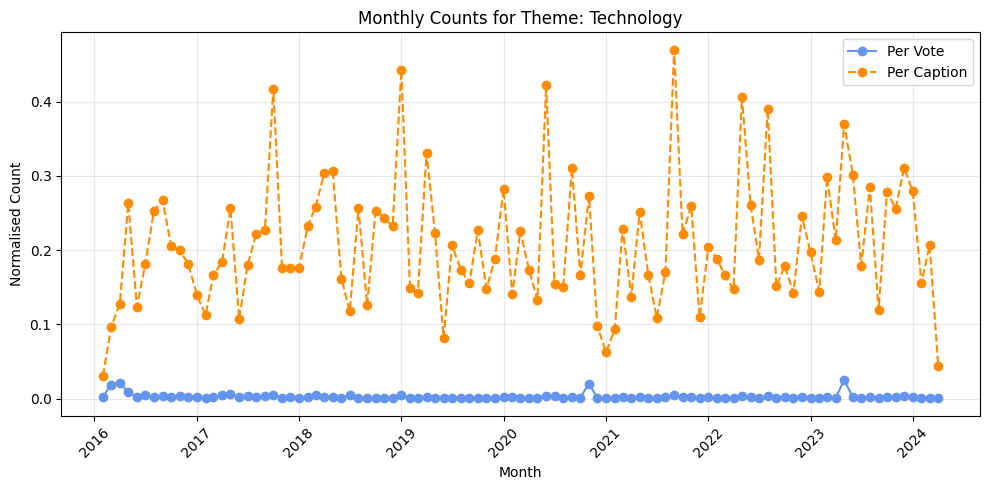

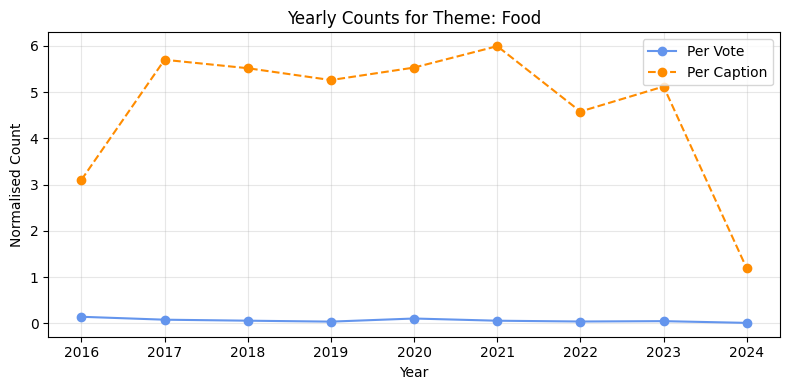

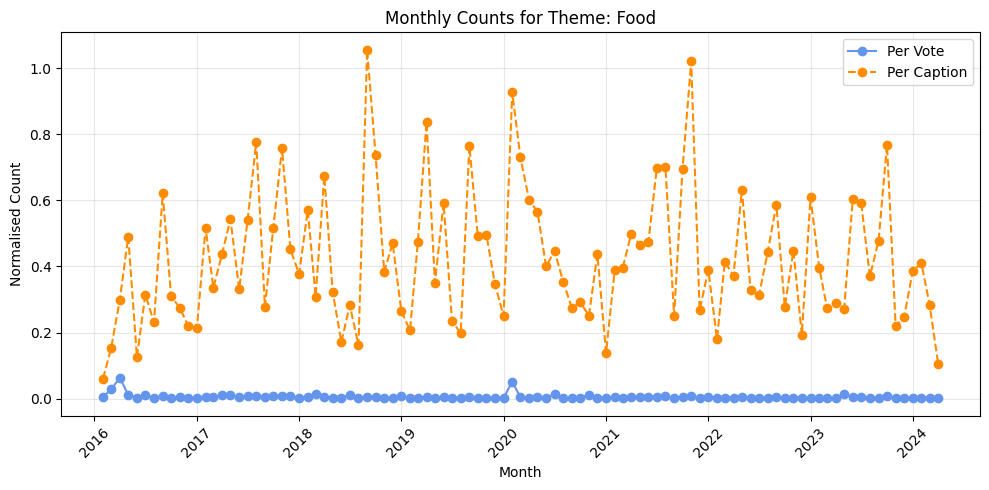

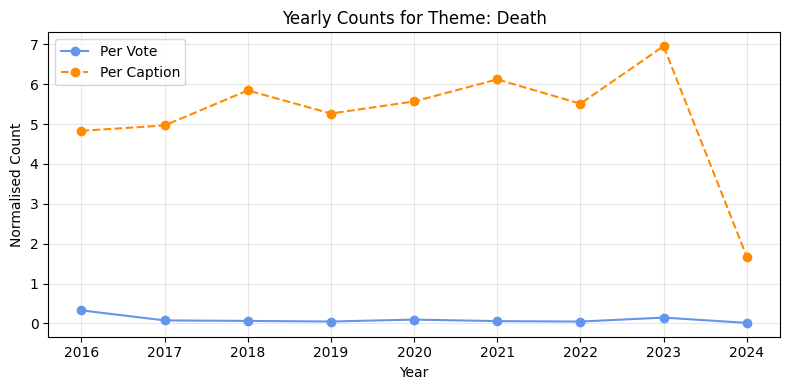

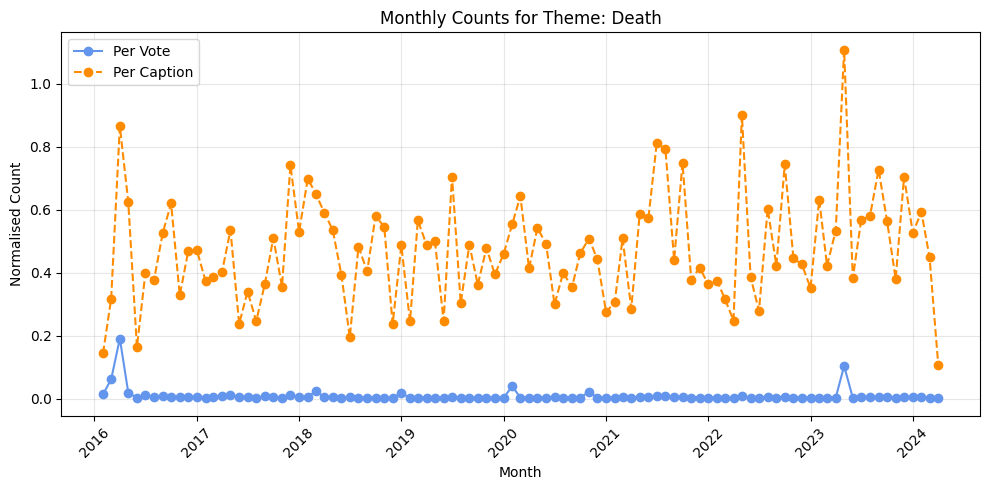

In [72]:

for theme, df in theme_time_dfs.items():
    # Extract year and month from the datetime column
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.to_period('M')

    # Groupintg by year
    yearly_counts = (
        df.groupby('year')[['count_per_vote', 'count_per_caption']]
        .sum()
        .reset_index()
    )

    plt.figure(figsize=(8, 4))
    plt.plot(yearly_counts['year'], yearly_counts['count_per_vote'],
             marker='o', label='Per Vote', color='cornflowerblue')
    plt.plot(yearly_counts['year'], yearly_counts['count_per_caption'],
             marker='o', label='Per Caption', color='darkorange', linestyle='--')
    plt.title(f'Yearly Counts for Theme: {theme.capitalize()}')
    plt.xlabel('Year')
    plt.ylabel('Normalised Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # grouping by month
    monthly_counts = (
        df.groupby('month')[['count_per_vote', 'count_per_caption']]
        .sum()
        .reset_index()
    )
    monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

    plt.figure(figsize=(10, 5))
    plt.plot(monthly_counts['month'], monthly_counts['count_per_vote'],
             marker='o', label='Per Vote', color='cornflowerblue')
    plt.plot(monthly_counts['month'], monthly_counts['count_per_caption'],
             marker='o', label='Per Caption', color='darkorange', linestyle='--')
    plt.title(f'Monthly Counts for Theme: {theme.capitalize()}')
    plt.xlabel('Month')
    plt.ylabel('Normalised Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [75]:

# Counters for both normalisations
taboo_time_series_votes = {theme: Counter() for theme in taboo_themes}
taboo_time_series_captions = {theme: Counter() for theme in taboo_themes}

# Aggregate per contest
for d in dataA4:
    # Each contest dataframe 'd' has one unique date
    date = d['date'].iloc[0] if not d['date'].isna().all() else None
    if pd.notna(date):
        # Normalisation factors
        total_votes = d['votes'].sum() if 'votes' in d.columns else 1
        total_captions = len(d)

        # Sum all caption-level taboo theme counts safely
        total_counts = sum((Counter(x) for x in d['taboo_theme_counts']), Counter())

        # Add to each taboo theme time series
        for theme, count in total_counts.items():
            if count > 0:
                taboo_time_series_votes[theme][date] += count / total_votes
                taboo_time_series_captions[theme][date] += count / total_captions

#Convert to DataFrames for each taboo theme
taboo_theme_time_dfs = {}
for theme in taboo_themes:
    df_votes = (
        pd.DataFrame.from_dict(taboo_time_series_votes[theme], orient='index', columns=['count_per_vote'])
        .reset_index().rename(columns={'index': 'date'})
    )
    df_captions = (
        pd.DataFrame.from_dict(taboo_time_series_captions[theme], orient='index', columns=['count_per_caption'])
        .reset_index().rename(columns={'index': 'date'})
    )
    df = pd.merge(df_votes, df_captions, on='date', how='outer').sort_values('date')
    taboo_theme_time_dfs[theme] = df



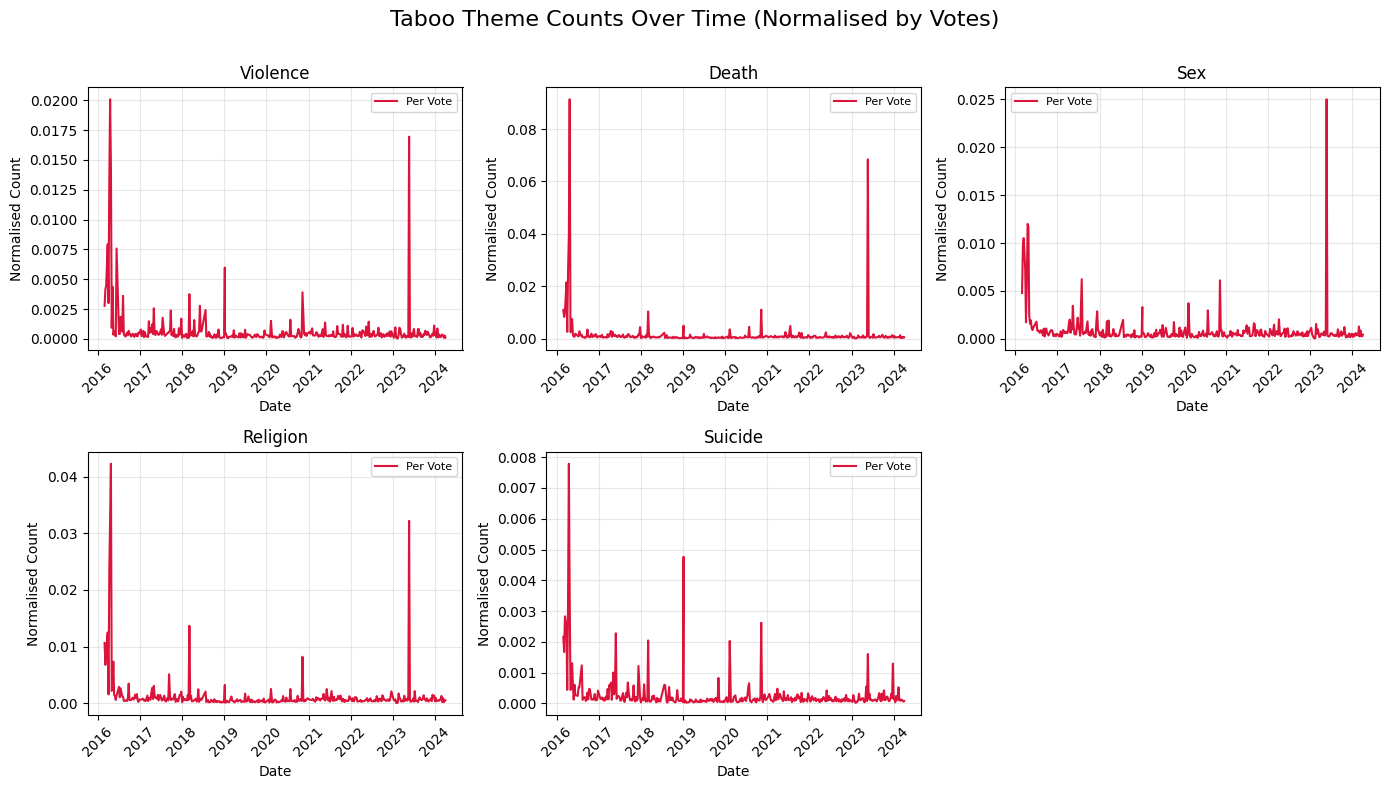

Text(0.5, 0.98, 'Taboo Theme Counts Over Time (Normalised by Votes and Captions)')

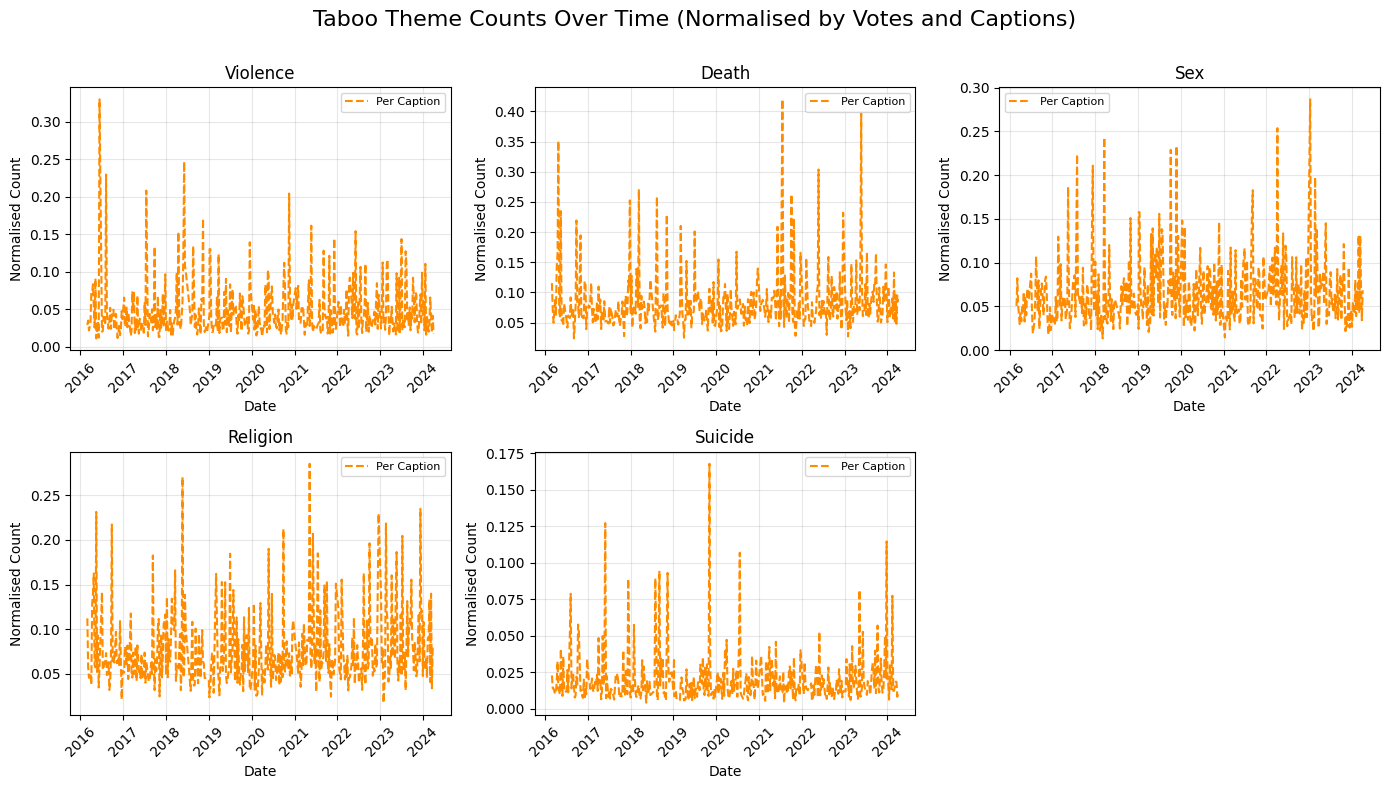

In [76]:
# Subplot of all taboo themes over time
plt.figure(figsize=(14, 8))
for i, (theme, df) in enumerate(taboo_theme_time_dfs.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(df['date'], df['count_per_vote'], label='Per Vote', color='crimson')
    plt.title(theme.capitalize())
    plt.xlabel('Date')
    plt.ylabel('Normalised Count')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout(rect=[0, 0, 1, 0.93])

plt.suptitle('Taboo Theme Counts Over Time (Normalised by Votes)', fontsize=16)
plt.show()

plt.figure(figsize=(14, 8))
for i, (theme, df) in enumerate(taboo_theme_time_dfs.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(df['date'], df['count_per_caption'], label='Per Caption', color='darkorange', linestyle='--')
    plt.title(theme.capitalize())
    plt.xlabel('Date')
    plt.ylabel('Normalised Count')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.suptitle('Taboo Theme Counts Over Time (Normalised by Votes and Captions)', fontsize=16)

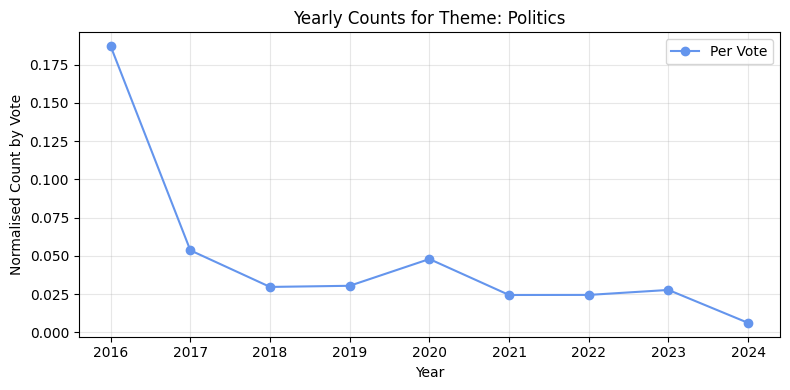

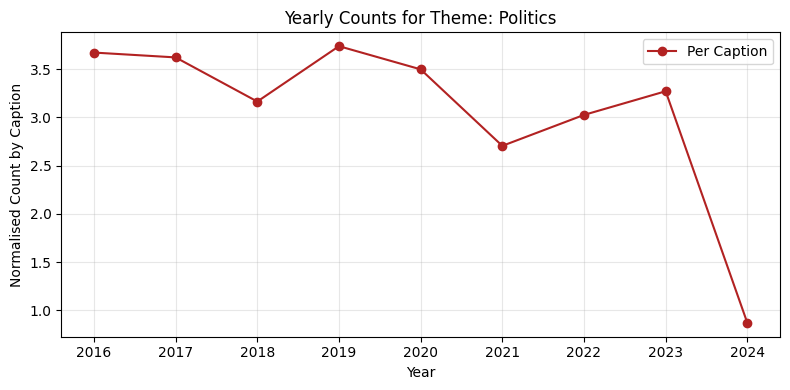

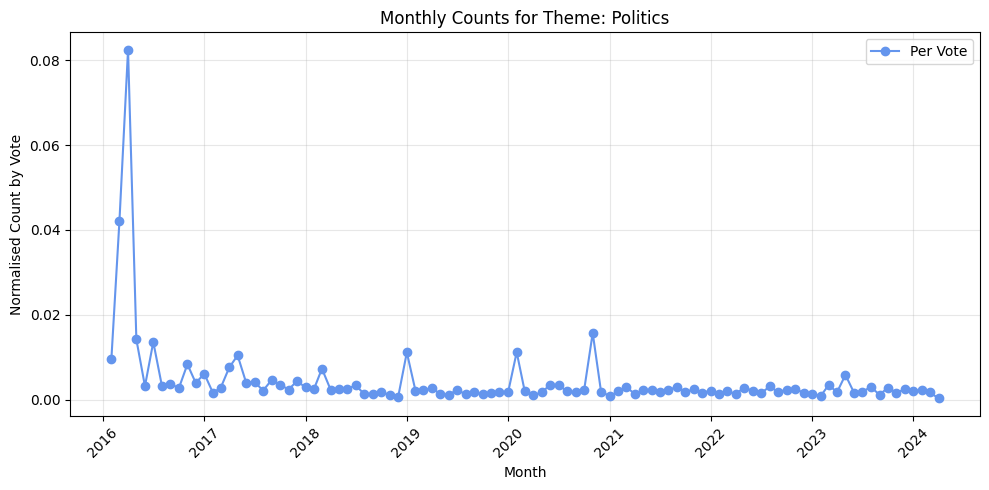

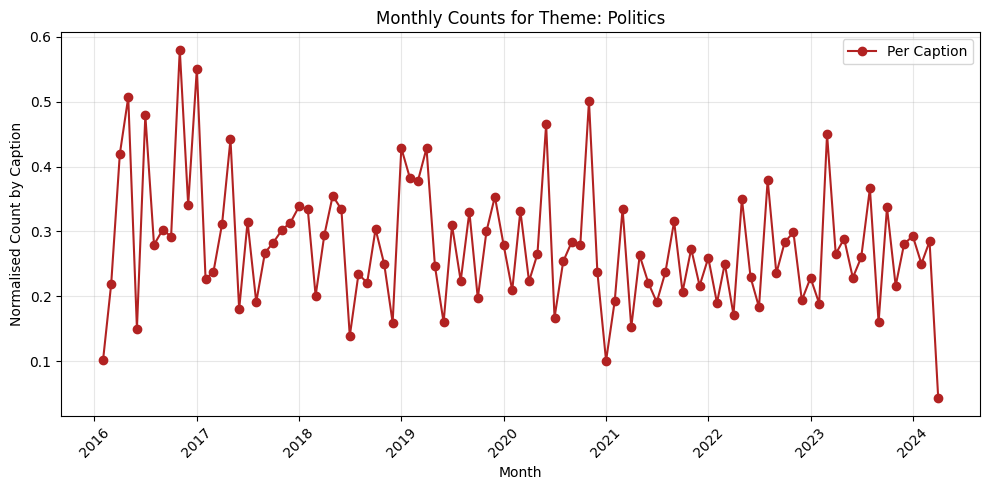

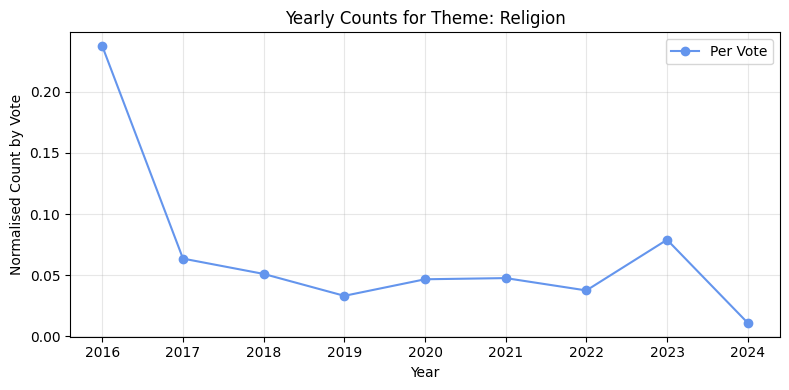

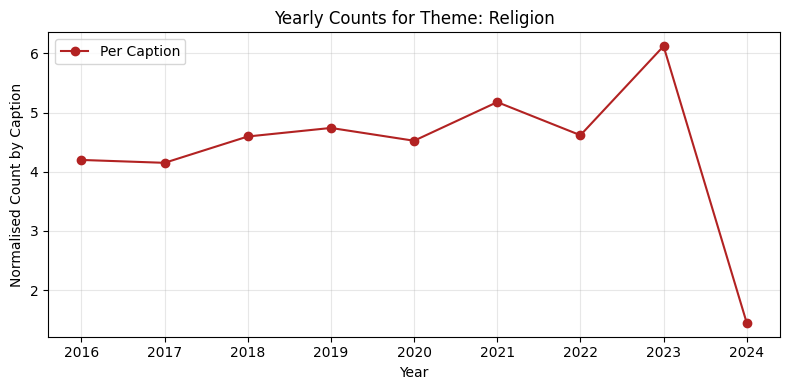

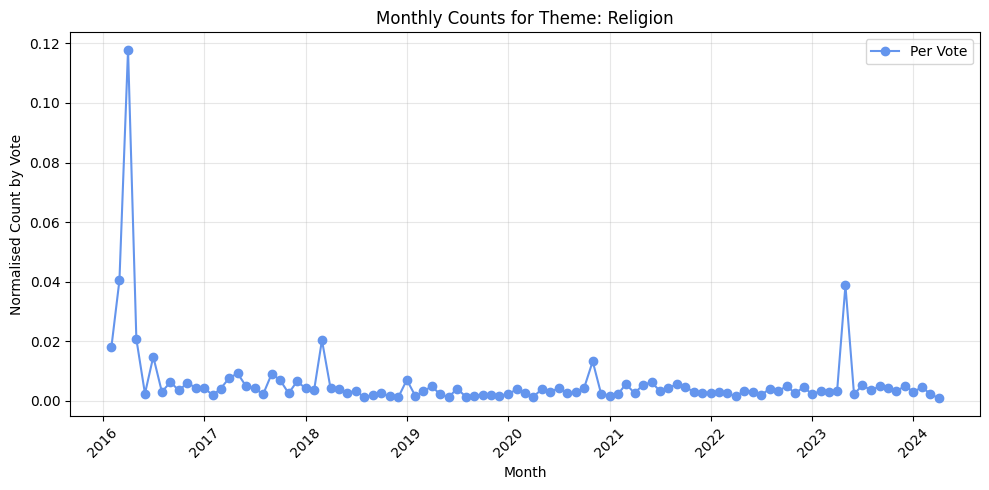

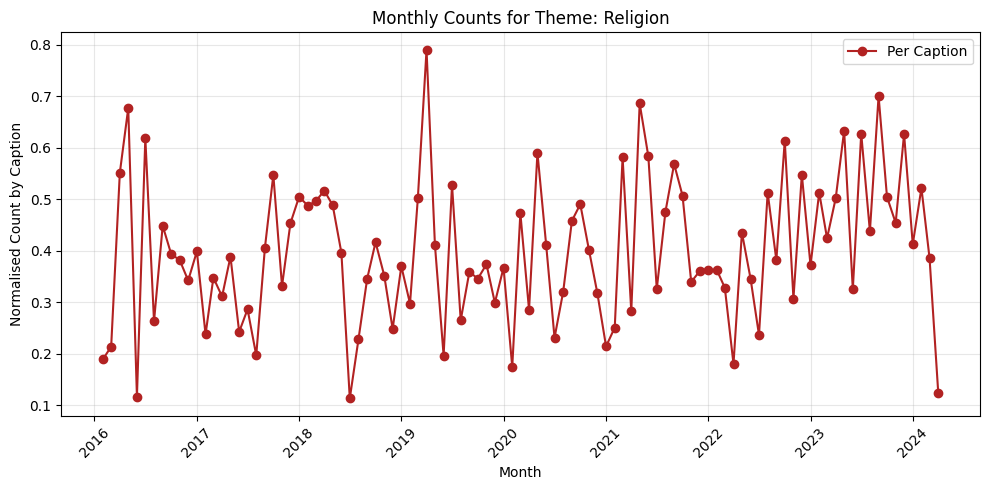

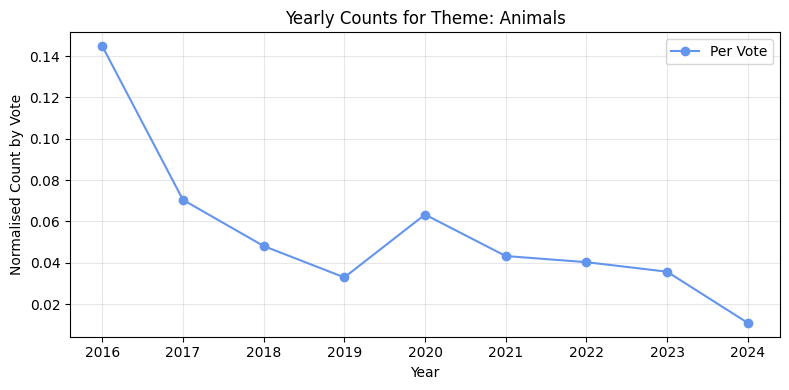

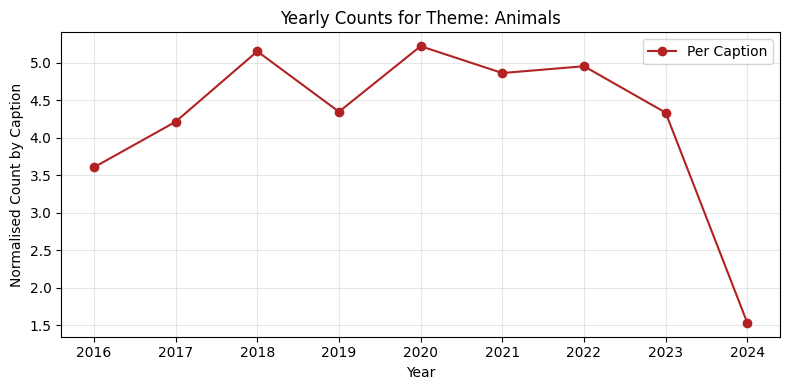

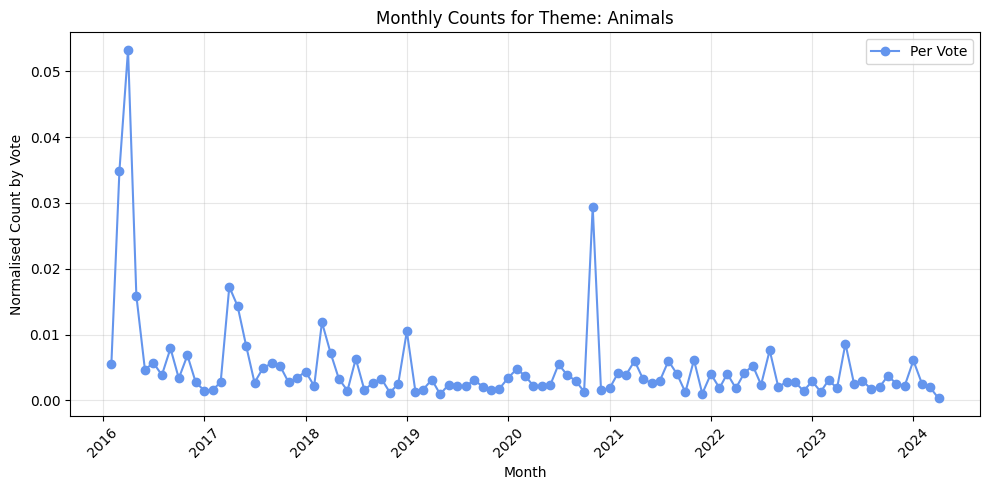

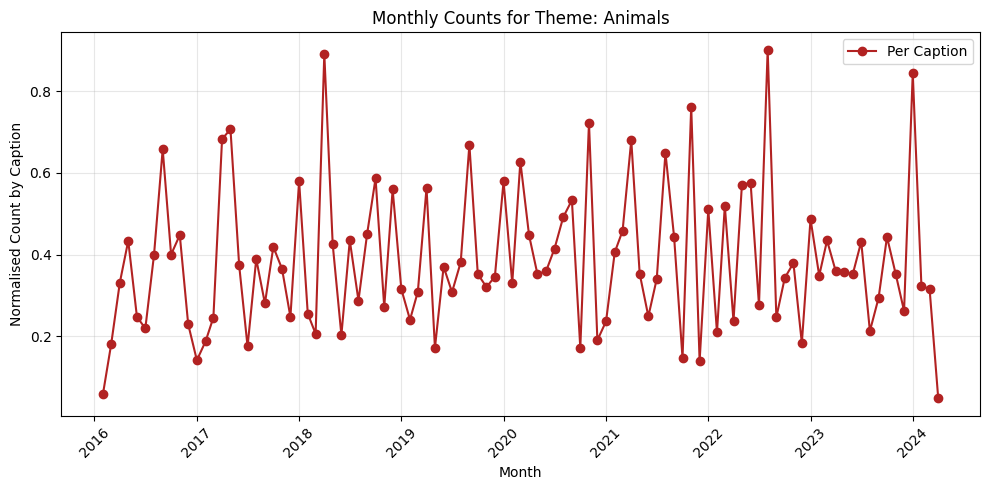

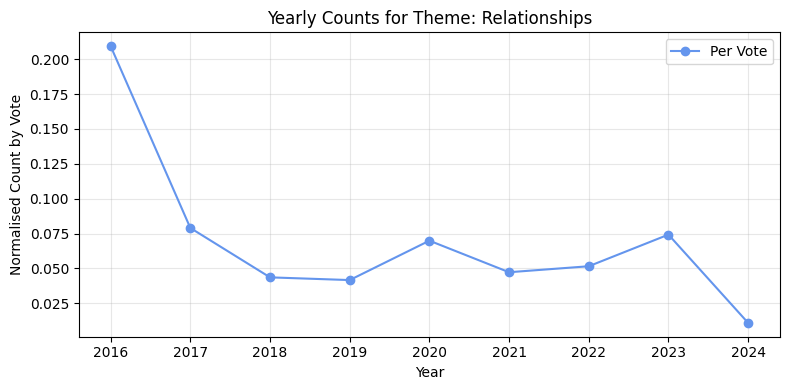

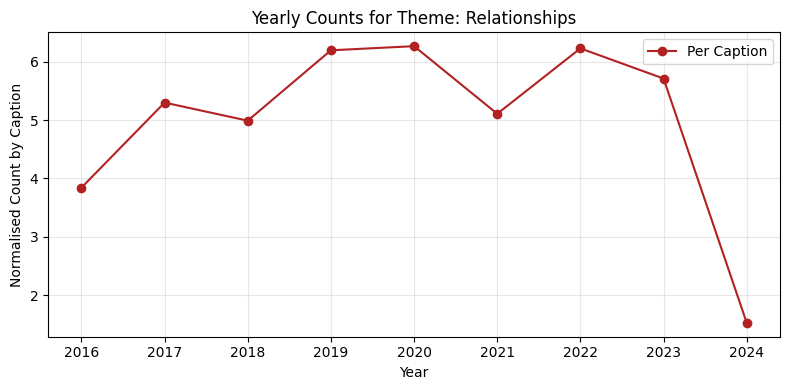

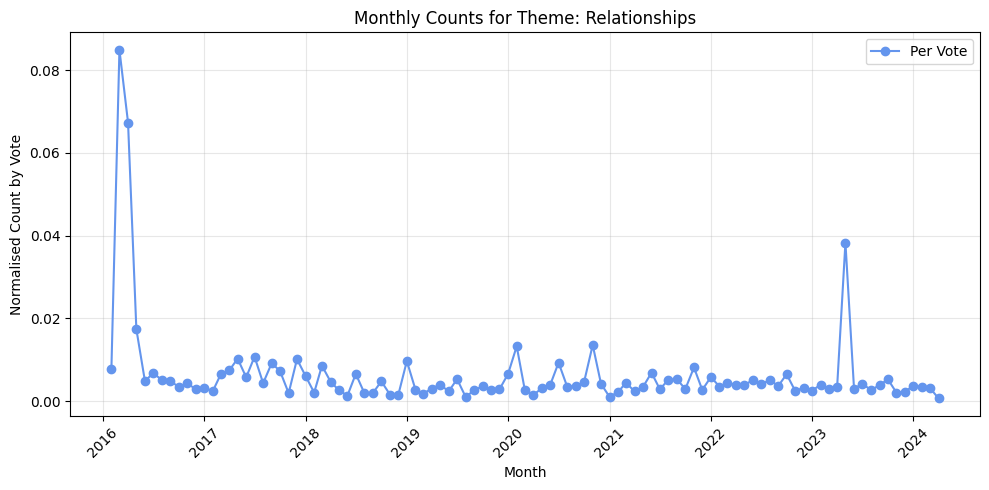

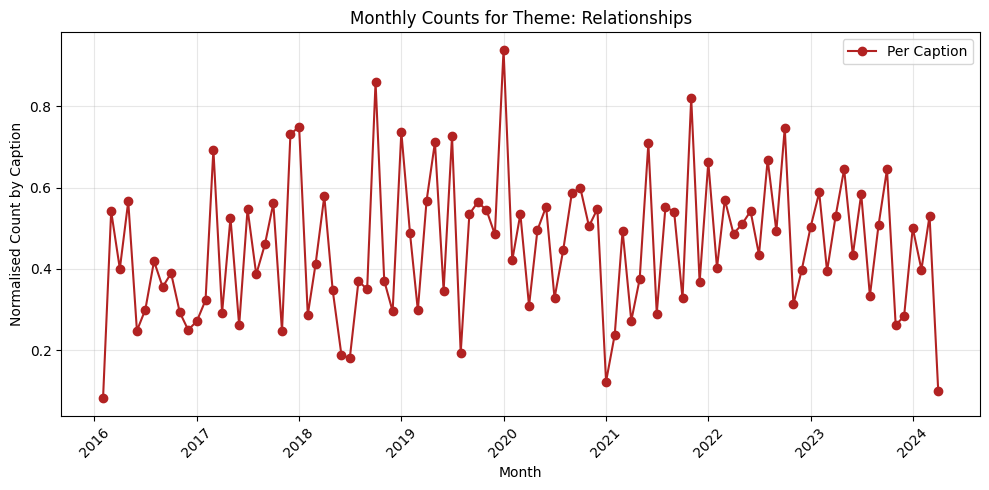

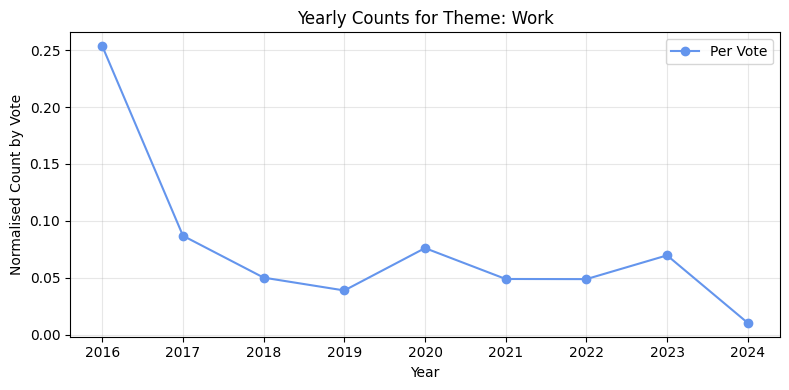

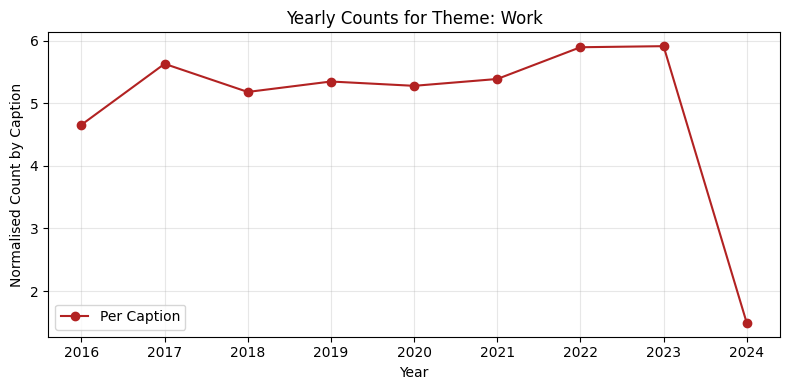

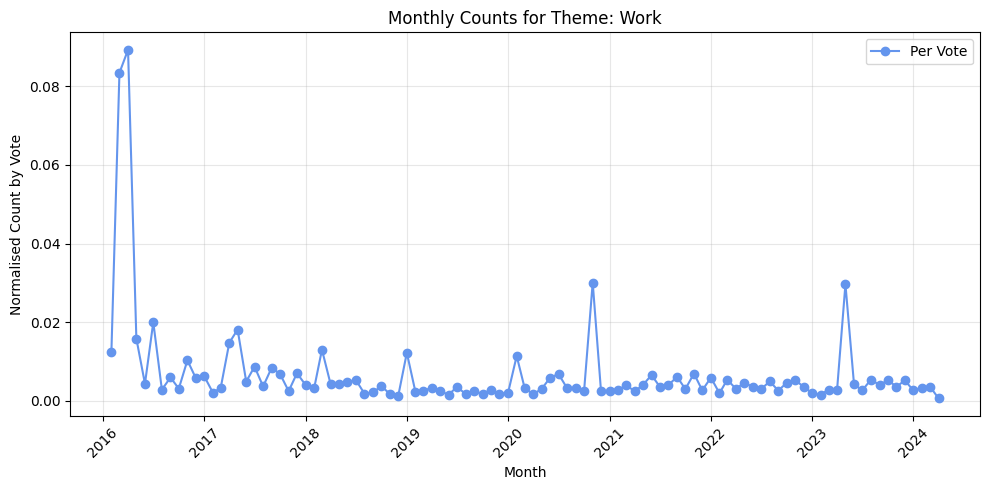

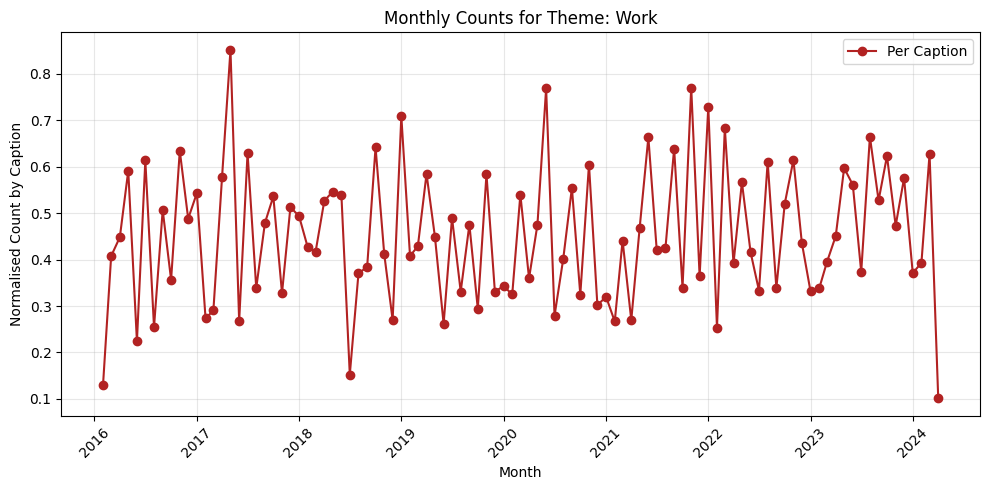

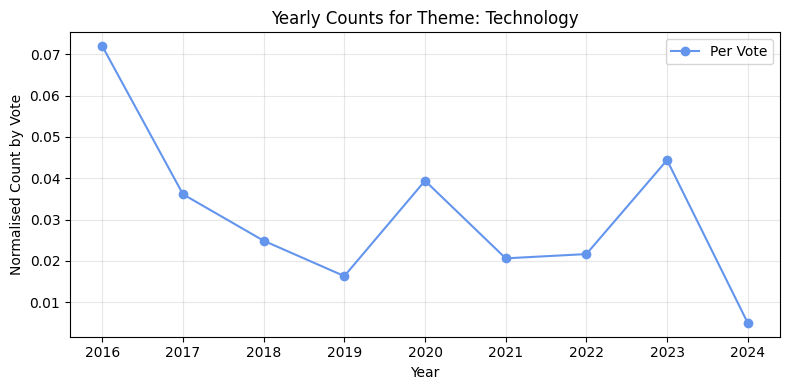

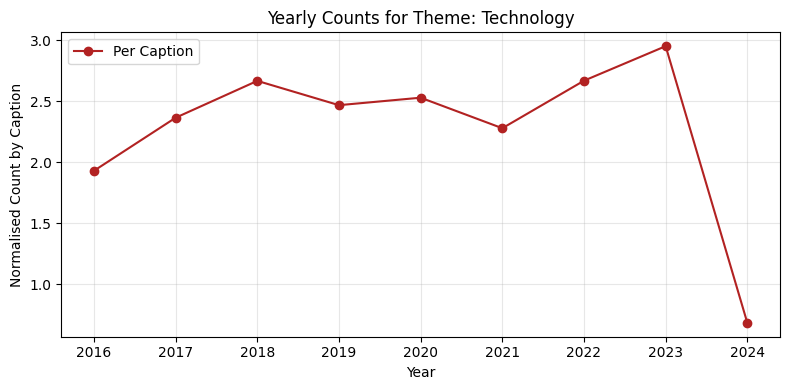

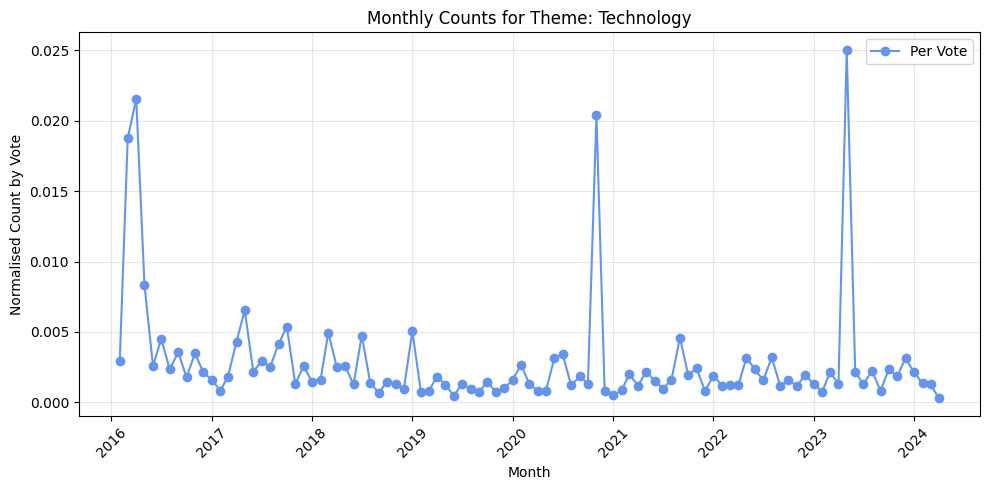

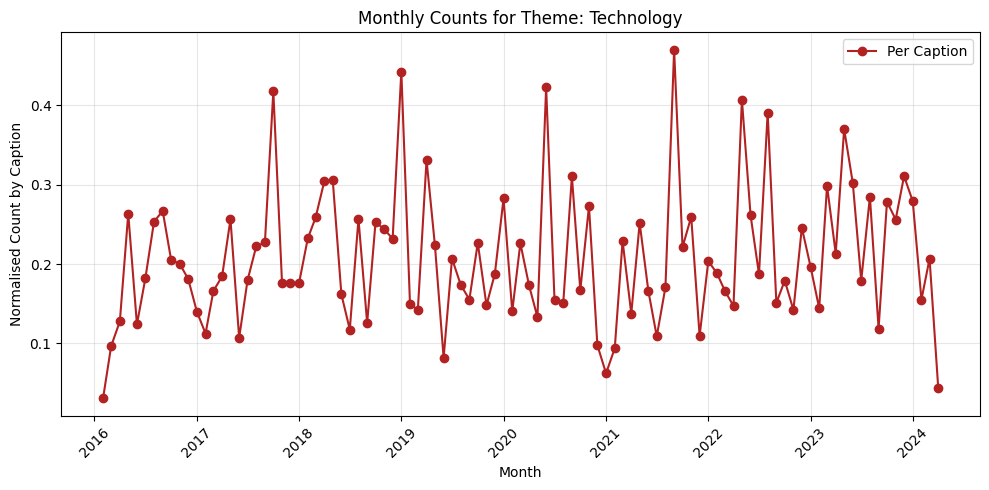

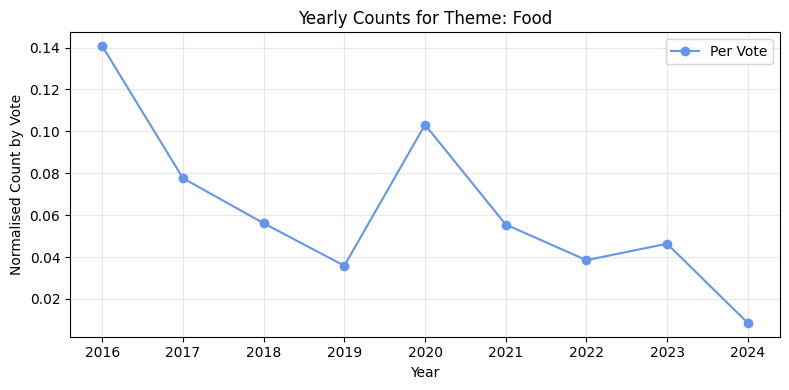

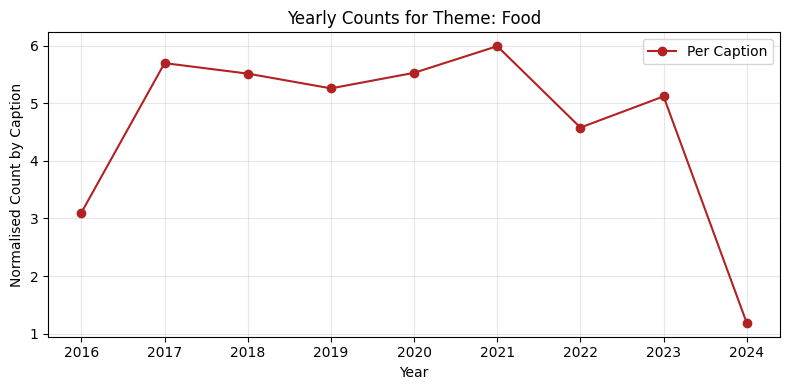

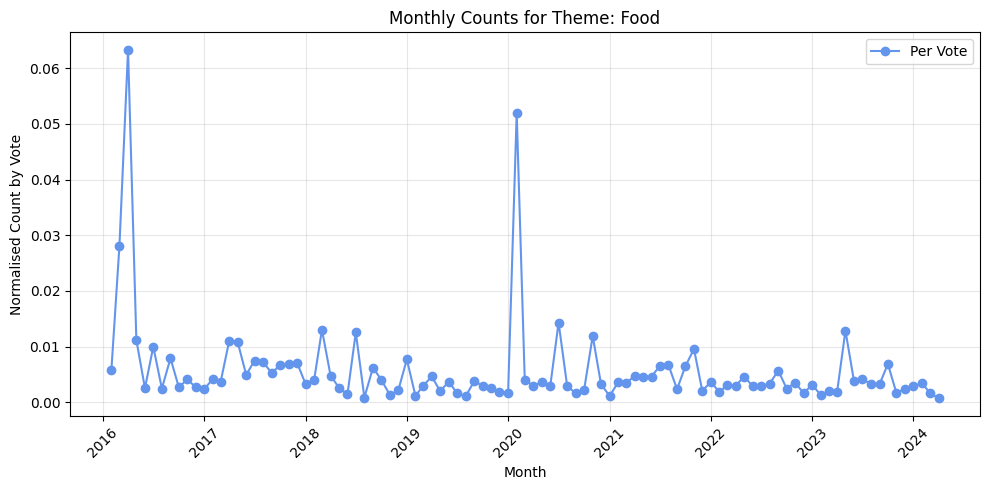

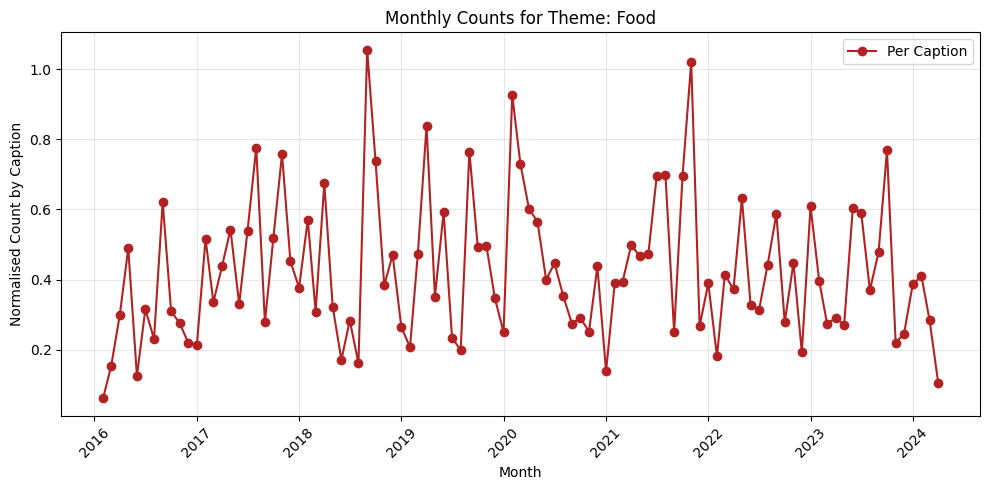

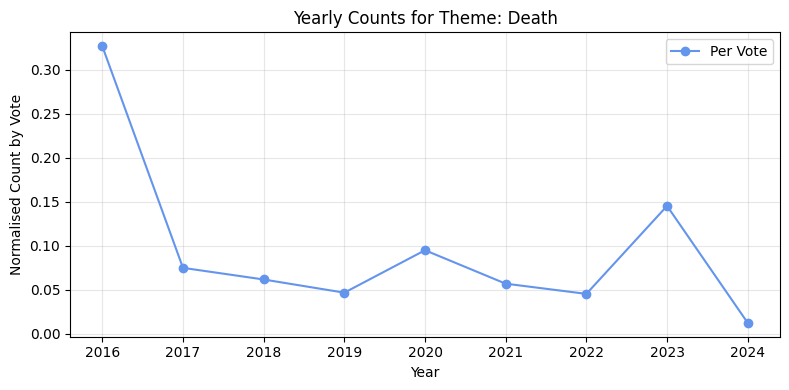

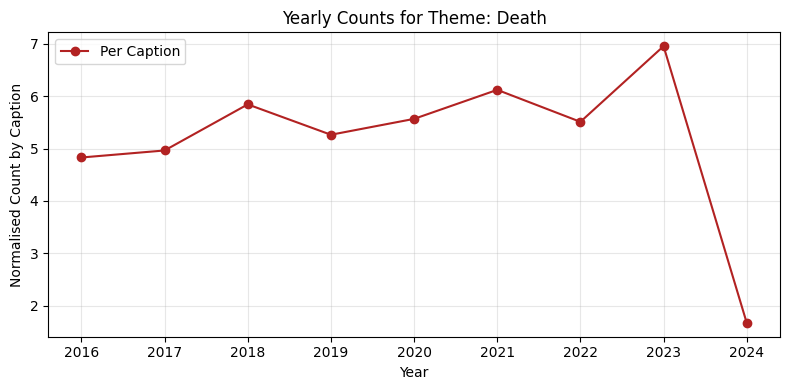

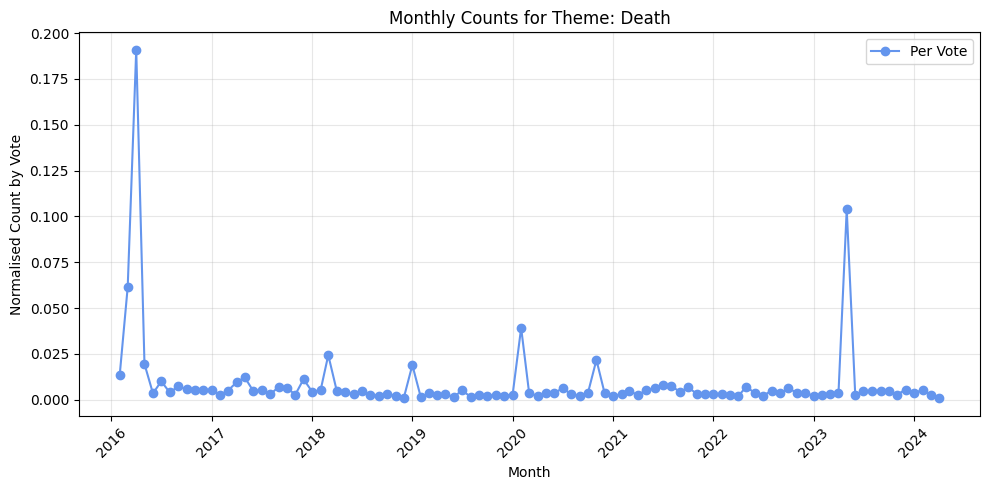

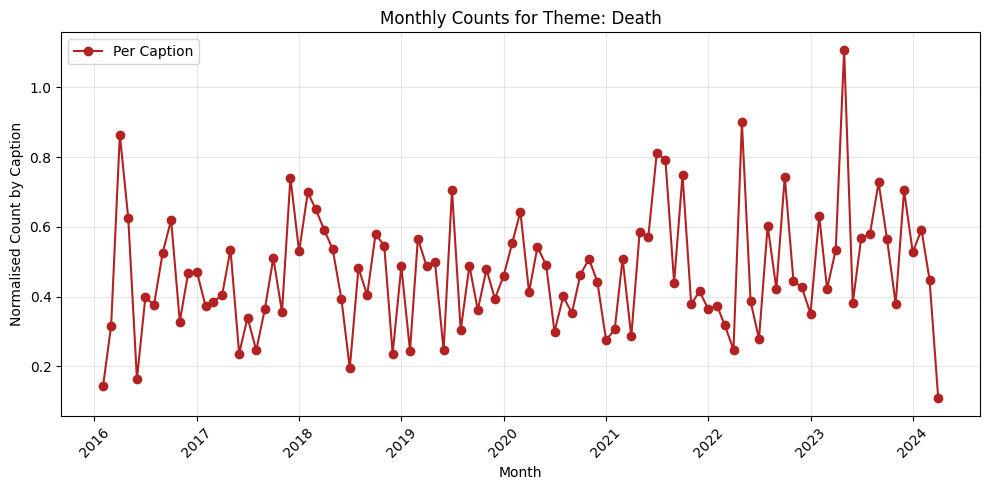

In [78]:

for theme, df in theme_time_dfs.items():
    # Extract year and month from the datetime column
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.to_period('M')

    # Groupintg by year
    yearly_counts = (
        df.groupby('year')[['count_per_vote', 'count_per_caption']]
        .sum()
        .reset_index()
    )

    plt.figure(figsize=(8, 4))
    plt.plot(yearly_counts['year'], yearly_counts['count_per_vote'],
             marker='o', label='Per Vote', color='cornflowerblue')
    plt.title(f'Yearly Counts for Theme: {theme.capitalize()}')
    plt.xlabel('Year')
    plt.ylabel('Normalised Count by Vote')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(yearly_counts['year'], yearly_counts['count_per_caption'],
             marker='o', label='Per Caption', color='firebrick')
    plt.title(f'Yearly Counts for Theme: {theme.capitalize()}')
    plt.xlabel('Year')
    plt.ylabel('Normalised Count by Caption')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # grouping by month
    monthly_counts = (
        df.groupby('month')[['count_per_vote', 'count_per_caption']]
        .sum()
        .reset_index()
    )
    monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

    plt.figure(figsize=(10, 5))
    plt.plot(monthly_counts['month'], monthly_counts['count_per_vote'],
             marker='o', label='Per Vote', color='cornflowerblue')
    
    plt.title(f'Monthly Counts for Theme: {theme.capitalize()}')
    plt.xlabel('Month')
    plt.ylabel('Normalised Count by Vote')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(monthly_counts['month'], monthly_counts['count_per_caption'],
             marker='o', label='Per Caption', color='firebrick')
    plt.title(f'Monthly Counts for Theme: {theme.capitalize()}')
    plt.xlabel('Month')
    plt.ylabel('Normalised Count by Caption')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

I will use an external database to see what jobs occur most often.

In [ ]:
#loading external dataset
occupations = pd.read_excel('Alphabetical-Index-of-Occupations-December-2019_Final.xlsx', skiprows=6)

occupations = occupations[['Description', '2018 Census Occupation Code', '2018 SOC Code']]
occupations = occupations.dropna().reset_index()

C:\Users\andra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


index                    Description  2018 Census Occupation Code  \
0          0                        Admiral                         10.0   
1          1                 Board chairman                         10.0   
2          2                   Board member                         10.0   
3          3                   Bureau chief                         10.0   
4          4  CEO (chief executive officer)                         10.0   
...      ...                            ...                          ...   
32667  32667                        Wheeler                       9760.0   
32668  32668                     Windlasser                       9760.0   
32669  32669                   Wire wheeler                       9760.0   
32670  32670                       Yarn man                       9760.0   
32671  32671                        Zanjero                       9760.0   

      2018 SOC Code  
0           11-1011  
1           11-1011  
2           11-1011  
3           11-1011  
4           11-1011  
...             ...  
32667       53-71XX  
32668       53-71XX  
32669       53-71XX  
32670       53-71XX  
32671       53-71XX  

[32672 rows x 4 columns]

In [17]:
import sys
sys.path.append("..")   # path *relative* to your notebook
from DataPreparation import dataA

# Precompile regex patterns for all jobs
patterns = [re.compile(rf"\b{re.escape(job)}\b", re.IGNORECASE) for job in occupations['Description']]

def find_jobs(text):
    return [job for job, pat in zip(occupations['Description'], patterns) if pat.search(text)]

#Create one huge dataframe with all captions
all_dataA = pd.DataFrame()
for data in dataA:
    all_data = pd.concat(all_dataA, data)


URLError: <urlopen error [Errno 11001] getaddrinfo failed>